# Genomic surveillance analysis in Germany

In [388]:
import matplotlib.pyplot as plt
import numpy as np
import numpyro as npy
import numpyro.distributions as dist
import pandas as pd
from jax import random
import geopandas as gpd
import genomicsurveillance as gs ## misc branch on github

assert npy.__version__.startswith("0.8.0")
%matplotlib inline
%config InlineBackend.figure_format='retina'
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams.update({'axes.grid': True,
                     'grid.linestyle': ':',
                     'axes.spines.bottom': False,
          'axes.spines.left': False,
          'axes.spines.right': False,
          'axes.spines.top': False})

In [389]:
from genomicsurveillance.misc import ancestor_matrix, alias

## Download data
### Map
With zip codes for geo matching

In [390]:
#plz = gpd.read_file("https://opendata.arcgis.com/datasets/5b203df4357844c8a6715d7d411a8341_0.geojson")
if plz is None:
    plz = gpd.read_file("data/5b203df4357844c8a6715d7d411a8341_0.geojson")
    bland = plz.set_index("plz")['bundesland']

### Sequences
From RKI's Github

In [391]:
! bash scripts/pipeline.sh

+ bash scripts/download_data.sh
+ mkdir -p data/compressed
+ curl -L https://github.com/robert-koch-institut/SARS-CoV-2-Sequenzdaten_aus_Deutschland/raw/master/SARS-CoV-2-Sequenzdaten_Deutschland.csv.xz
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 59.7M  100 59.7M    0     0  1398k      0  0:00:43  0:00:43 --:--:-- 1598k    0   383k      0  0:02:39  0:00:05  0:02:34  556k
+ curl -L https://github.com/robert-koch-institut/SARS-CoV-2-Sequenzdaten_aus_Deutschland/raw/master/SARS-CoV-2-Entwicklungslinien_Deutschland.csv.xz
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 22.6M  100 22.6M    0     0   593k    

In [392]:
df = pd.read_csv(
    'data/meta_lineages.csv',
    index_col=0,
    parse_dates=[1,3],
    infer_datetime_format=True,
    cache_dates=True,
    dtype = {'SEQ_REASON': 'category',
             'SENDING_LAB_PC': 'category',
             'SEQUENCING_LAB_PC': 'category',
             'lineage': 'category',
             'scorpio_call': 'category'
             }
)
df.rename(columns={
    'DATE_DRAW': 'date',
    'PROCESSING_DATE': 'processing_date',
    'SEQ_REASON': 'reason',
    'SENDING_LAB_PC': 'sending_pc',
    'SEQUENCING_LAB_PC': 'sequencing_pc',
    'lineage': 'lineage',
    'scorpio_call': 'scorpio'
    },
    inplace=True
)

In [393]:
df = df[~ pd.isna(df.sending_pc)]
df.sending_pc = df.sending_pc.cat.rename_categories({x:f"{float(x):05.0f}" for x in df.sending_pc.cat.categories}) # = df.sending_pc.astype('str').astype('category')


In [394]:

df = df.merge(bland, left_on='sending_pc', right_index=True)#.dropna()


In [395]:
df.reason.value_counts()

N                             564536
X                             339271
Y                              36329
A[B.1.617.2]                   35840
A[B.1.1.7]                     35832
                               ...  
A[B1.1.529]                        0
A[E484K/N501Y/P681R]               0
A[E484E/N501N/P681R]               0
A[KONTAKTMITENGL.MUTATION]         0
A[B1.627.2]                        0
Name: reason, Length: 232, dtype: int64

In [396]:
import re

In [397]:
df

date reason  \
IMS_ID                                                                 
IMS-10294-CVDP-00001                               2021-01-14      X   
IMS-10294-CVDP-00325                               2020-11-08      X   
IMS-10294-CVDP-00326                               2020-11-08      X   
IMS-10294-CVDP-00327                               2020-11-08      X   
IMS-10294-CVDP-00329                               2020-11-09      X   
...                                                       ...    ...   
IMS-10594-CVDP-D23ABEF6-ACA2-4F4E-9685-231B3045... 2022-08-02      Y   
IMS-10594-CVDP-1A2555BE-AC43-4B9B-8123-B5C33BFE... 2022-08-05      Y   
IMS-10594-CVDP-7E039F95-BE2E-46D1-BA3B-8E158BF6... 2022-08-02      Y   
IMS-10594-CVDP-B2D26BEB-613A-4818-887F-7EA0F303... 2022-08-05      Y   
IMS-10184-CVDP-6BE4FE02-67B1-43BE-AA67-8EA60823... 2022-08-16      N   

                                                   processing_date sending_pc  \
IMS_ID                                                                          
IMS-10294-CVDP-00001                                    2021-01-25      40225   
IMS-10294-CVDP-00325                                    2021-02-14      40225   
IMS-10294-CVDP-00326                                    2021-02-14      40225   
IMS-10294-CVDP-00327                                    2021-02-14      40225   
IMS-10294-CVDP-00329                                    2021-02-14      40225   
...                                                            ...        ...   
IMS-10594-CVDP-D23ABEF6-ACA2-4F4E-9685-231B3045...      2022-08-16      55131   
IMS-10594-CVDP-1A2555BE-AC43-4B9B-8123-B5C33BFE...      2022-08-16      55131   
IMS-10594-CVDP-7E039F95-BE2E-46D1-BA3B-8E158BF6...      2022-08-16      55131   
IMS-10594-CVDP-B2D26BEB-613A-4818-887F-7EA0F303...      2022-08-16      55131   
IMS-10184-CVDP-6BE4FE02-67B1-43BE-AA67-8EA60823...      2022-08-22      33617   

                                                   sequencing_pc    lineage  \
IMS_ID                                                                        
IMS-10294-CVDP-00001                                       40225  B.1.1.297   
IMS-10294-CVDP-00325                                       40225    B.1.221   
IMS-10294-CVDP-00326                                       40225    B.1.160   
IMS-10294-CVDP-00327                                       40225    B.1.258   
IMS-10294-CVDP-00329                                       40225  B.1.1.521   
...                                                          ...        ...   
IMS-10594-CVDP-D23ABEF6-ACA2-4F4E-9685-231B3045...         55131     BA.5.1   
IMS-10594-CVDP-1A2555BE-AC43-4B9B-8123-B5C33BFE...         55131    BA.2.61   
IMS-10594-CVDP-7E039F95-BE2E-46D1-BA3B-8E158BF6...         55131     BA.4.7   
IMS-10594-CVDP-B2D26BEB-613A-4818-887F-7EA0F303...         55131     BE.1.1   
IMS-10184-CVDP-6BE4FE02-67B1-43BE-AA67-8EA60823...         24106     BA.5.2   

                                                   scorpio  \
IMS_ID                                                       
IMS-10294-CVDP-00001                                   NaN   
IMS-10294-CVDP-00325                                   NaN   
IMS-10294-CVDP-00326                                   NaN   
IMS-10294-CVDP-00327                                   NaN   
IMS-10294-CVDP-00329                                   NaN   
...                                                    ...   
IMS-10594-CVDP-D23ABEF6-ACA2-4F4E-9685-231B3045...     NaN   
IMS-10594-CVDP-1A2555BE-AC43-4B9B-8123-B5C33BFE...     NaN   
IMS-10594-CVDP-7E039F95-BE2E-46D1-BA3B-8E158BF6...     NaN   
IMS-10594-CVDP-B2D26BEB-613A-4818-887F-7EA0F303...     NaN   
IMS-10184-CVDP-6BE4FE02-67B1-43BE-AA67-8EA60823...     NaN   

                                                             bundesland  
IMS_ID                                                                   
IMS-10294-CVDP-00001                                Nordrhein-Westfalen  
IMS-10294

In [398]:
df.lineage[df.date > np.datetime64("today") - np.timedelta64(30, "D")].cat.remove_unused_categories().value_counts()

BA.5.1        3013
BA.5.2        2677
BA.5.2.1      1830
BE.1.1        1546
BF.7           327
              ... 
BA.4.2           1
BA.5.1.12        1
BA.5.6.1         1
BE.1.2           1
B.1.177.86       1
Name: lineage, Length: 89, dtype: int64

In [399]:
d = df.loc[df.date >= "2021-11-01",:]
d = d[d.reason.isin(['N','X'])]
d = d[d.lineage != "None"]
d.lineage = d.lineage.cat.remove_unused_categories().cat.add_categories(['Other'])
l = d.lineage.cat.categories#remove_unused_categories()

In [400]:
ba = [x for x in l if alias(x, anti_alias=True).startswith('B.1.1.529') ]
ba

['BA.1',
 'BA.1.1',
 'BA.1.1.1',
 'BA.1.13',
 'BA.1.14.1',
 'BA.1.15',
 'BA.1.17',
 'BA.1.17.2',
 'BA.1.18',
 'BA.1.19',
 'BA.1.21',
 'BA.1.9',
 'B.1.1.529',
 'BA.1.1.10',
 'BA.1.1.11',
 'BA.1.1.13',
 'BA.1.1.14',
 'BA.1.1.15',
 'BA.1.1.16',
 'BA.1.1.18',
 'BA.1.1.2',
 'BA.1.1.3',
 'BA.1.10',
 'BA.1.12',
 'BA.1.14',
 'BA.1.15.1',
 'BA.1.16',
 'BA.1.20',
 'BA.1.21.1',
 'BA.1.4',
 'BA.1.5',
 'BA.1.7',
 'BA.1.8',
 'BA.2',
 'BA.2.9',
 'BA.3',
 'BA.1.1.12',
 'BA.1.1.17',
 'BA.1.1.4',
 'BA.1.1.6',
 'BA.1.1.7',
 'BA.1.1.8',
 'BA.1.1.9',
 'BA.1.13.1',
 'BA.1.14.2',
 'BA.1.15.2',
 'BA.1.15.3',
 'BA.1.16.2',
 'BA.1.6',
 'BA.2.1',
 'BA.2.10',
 'BA.2.10.1',
 'BA.2.10.3',
 'BA.2.12',
 'BA.2.13',
 'BA.2.14',
 'BA.2.19',
 'BA.2.23',
 'BA.2.3',
 'BA.2.3.15',
 'BA.2.36',
 'BA.2.37',
 'BA.2.39',
 'BA.2.4',
 'BA.2.5',
 'BA.2.65',
 'BA.2.7',
 'BA.2.9.3',
 'BA.2.9.5',
 'BC.2',
 'BD.1',
 'BA.1.17.1',
 'BA.1.2',
 'BA.2.25',
 'BA.2.29',
 'BA.2.3.5',
 'BA.2.32',
 'BA.2.33',
 'BA.2.38',
 'BA.2.45',
 'BA.2.47',


In [401]:
#d.lineage[d.lineage.isna()] = 'Other'
#d.loc[~d.lineage.isin(['BA.1','BA.1.1','BA.2','BA.3','B.1.1.529']),"lineage"] = "Delta/Other"
d.lineage.iloc[d.lineage.apply(lambda x: re.match("AY",x) is not None).astype("Bool")] = "B.1.617.2"
d.loc[~d.lineage.isin(['BA.1','BA.1.1','BA.2','BA.3','B.1.1.529','B.1.617.2'] + ba),"lineage"] = "Other"
d.lineage = d.lineage.cat.remove_unused_categories()#.cat.add_categories(['BA.2.40'])
genomes = pd.crosstab(index=[d.bundesland, d.date], columns=d.lineage, dropna=False).fillna(0)
#genomes.loc["Baden-Württemberg"]
genomes = genomes.iloc[:,[(i + 1) % genomes.shape[1] for i in range(genomes.shape[1])]]
genomes

lineage                       BA.1  BA.1.1  BA.1.1.1  BA.1.13  BA.1.14.1  \
bundesland        date                                                     
Baden-Württemberg 2021-11-01     0       0         0        0          0   
                  2021-11-02     0       0         0        0          0   
                  2021-11-03     0       0         0        0          0   
                  2021-11-04     0       0         0        0          0   
                  2021-11-05     0       0         0        0          0   
...                            ...     ...       ...      ...        ...   
Thüringen         2022-08-27     0       0         0        0          0   
                  2022-08-28     0       0         0        0          0   
                  2022-08-29     0       0         0        0          0   
                  2022-08-30     0       0         0        0          0   
                  2022-08-31     0       0         0        0          0   

lineage                       BA.1.15  BA.1.17  BA.1.17.2  BA.1.18  BA.1.19  \
bundesland        date                                                        
Baden-Württemberg 2021-11-01        0        0          0        0        0   
                  2021-11-02        0        0          0        0        0   
                  2021-11-03        0        0          0        0        0   
                  2021-11-04        0        0          0        0        0   
                  2021-11-05        0        0          0        0        0   
...                               ...      ...        ...      ...      ...   
Thüringen         2022-08-27        0        0          0        0        0   
                  2022-08-28        0        0          0        0        0   
                  2022-08-29        0        0          0        0        0   
                  2022-08-30        0        0          0        0        0   
                  2022-08-31        0        0          0        0        0   

lineage                       ...  BA.5.2.4  BA.5.2.5  BA.5.6.1  BE.1.2  \
bundesland        date        ...                                         
Baden-Württemberg 2021-11-01  ...         0         0         0       0   
                  2021-11-02  ...         0         0         0       0   
                  2021-11-03  ...         0         0         0       0   
                  2021-11-04  ...         0         0         0       0   
                  2021-11-05  ...         0         0         0       0   
...                           ...       ...       ...       ...     ...   
Thüringen         2022-08-27  ...         0         0         0       0   
                  2022-08-28  ...         0         0         0       0   
                  2022-08-29  ...         0         0         0       0   
                  2022-08-30  ...         0         0         0       0   
                  2022-08-31  ...         0         0         0       0   

lineage                       BF.13  BF.9  BH.1  BK.1  Other  B.1.617.2  
bundesland        date                                                   
Baden-Württemberg 2021-11-01      0     0     0     0      0        142  
                  2021-11-02      0     0     0     0      0        350  
                  2021-11-03      0     0     0     0      0        704  
                  2021-11-04      0     0     0     0      0       1044  
                  2021-11-05      0     0     0     0      0       1210  
...                             ...   ...   ...   ...    ...        ...  
Thüringen         2022-08-27      0     0     0     0      0          0  
                  2022-08-28      0     0     0     0      0          0  
                  2022-08-29      0     0     0     0      0          0  
                  2022-08-30      0     0     0     0      0          0  
                  2022-08-31      0     0     0     0      0          0  

[4864 rows x 245 columns]

In [402]:
with pd.option_context('display.max_rows', None,):
    s = genomes.sum(level=1).loc["2022-06-01":,"BA.2.75"]
    t =  genomes.sum(level=1).loc["2022-06-01":,:].sum(1)
    print(pd.DataFrame({"BA.2.75":s, "total":t}))#/genomes.sum(level=1).loc["2022-06-01":,:].sum(1))

            BA.2.75  total
date                      
2022-06-01        0   1541
2022-06-02        0   1675
2022-06-03        1   1073
2022-06-04        0    735
2022-06-05        0    564
2022-06-06        1    649
2022-06-07        0   2444
2022-06-08        0   2252
2022-06-09        0   2287
2022-06-10        0   1650
2022-06-11        0    803
2022-06-12        0    451
2022-06-13        0   2565
2022-06-14        0   1876
2022-06-15        0   2222
2022-06-16        0    949
2022-06-17        0   1518
2022-06-18        0    727
2022-06-19        0    375
2022-06-20        0   1789
2022-06-21        0   2150
2022-06-22        0   1800
2022-06-23        0   2430
2022-06-24        1   2001
2022-06-25        0   1089
2022-06-26        0    890
2022-06-27        2   3278
2022-06-28        0   2558
2022-06-29        0   2116
2022-06-30        0   2344
2022-07-01        0   1613
2022-07-02        0    842
2022-07-03        0    810
2022-07-04        0   1958
2022-07-05        0   2036
2

In [403]:
with pd.option_context('display.max_rows', None,):
    print(genomes.sum(level=1).loc["2022-06-01":,[x for x in genomes.columns if x.startswith("BA.2.75")]])

lineage     BA.2.75  BA.2.75.1  BA.2.75.2  BA.2.75.5
date                                                
2022-06-01        0          0          0          0
2022-06-02        0          0          0          0
2022-06-03        1          0          0          0
2022-06-04        0          0          0          0
2022-06-05        0          0          0          0
2022-06-06        1          0          0          0
2022-06-07        0          0          0          0
2022-06-08        0          0          0          0
2022-06-09        0          0          0          0
2022-06-10        0          0          0          0
2022-06-11        0          0          0          0
2022-06-12        0          0          0          0
2022-06-13        0          0          0          0
2022-06-14        0          0          0          0
2022-06-15        0          0          0          0
2022-06-16        0          0          0          0
2022-06-17        0          0          0     

Text(0, 0.5, '14d log odds Aug 1-15 / Jul 15-30')

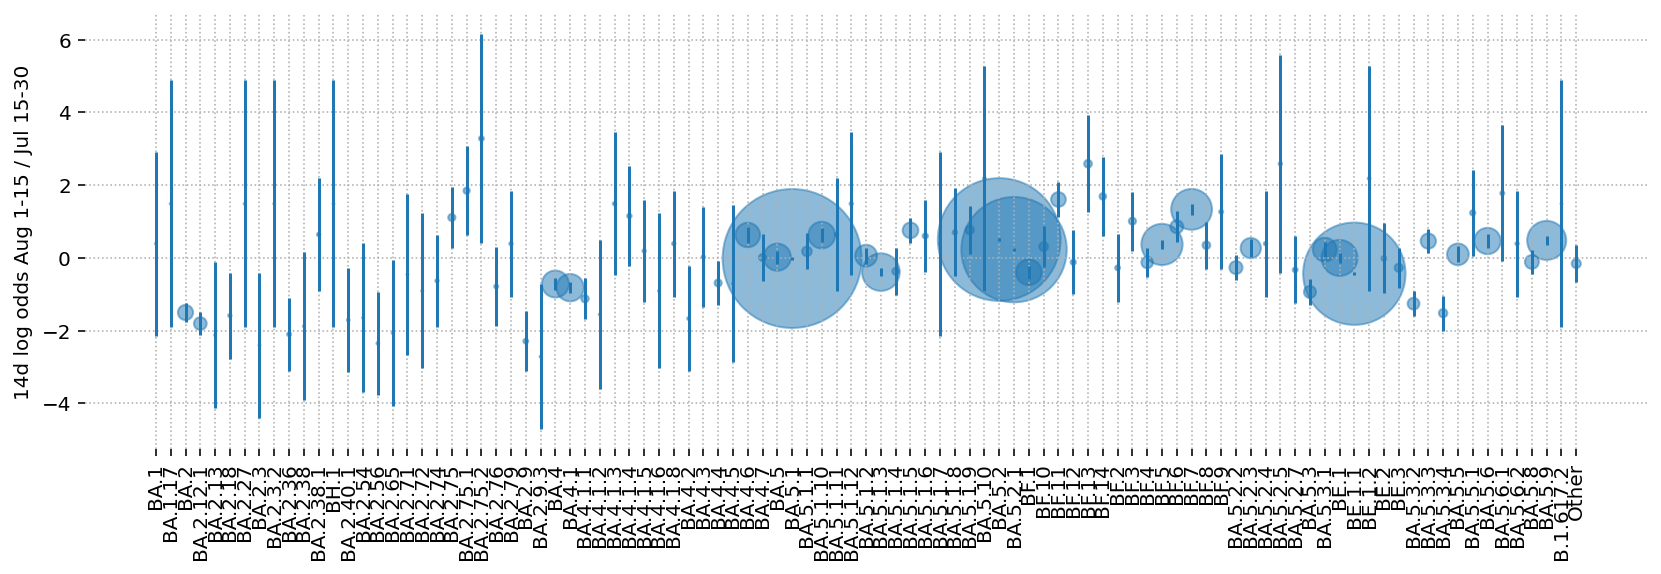

In [404]:
g = genomes.sum(level=1)
g.columns =  [alias(alias(x, anti_alias=True)) for x in g.columns]
h = g.loc["2022-08-01":].sum(0) #+.5
i = g.loc["2022-07-01":"2022-07-30"].sum(0) +.5
f = h[h>0]/i[h>0] * i.sum()/h.sum()
f.index = [alias(x, anti_alias=True) for x in f.index]
f = f.sort_index()
f.index = [alias(x) for x in f.index]
n = h[h>0]
e = np.sqrt(1./h[h>0] + 1./i[h>0] + 1./i.sum() + 1./h.sum())
#e.index = [alias(alias(x, anti_alias=True)) for x in e.index]
plt.figure(figsize=(14,4))
plt.scatter(f.index, np.log(f), s=n[f.index], alpha=0.5)
plt.errorbar(f.index, np.log(f), yerr=1.96*e[f.index], ls="")
_ = plt.xticks(rotation=90)
plt.ylabel("14d log odds Aug 1-15 / Jul 15-30")

Text(0, 0.5, 'Fold change')

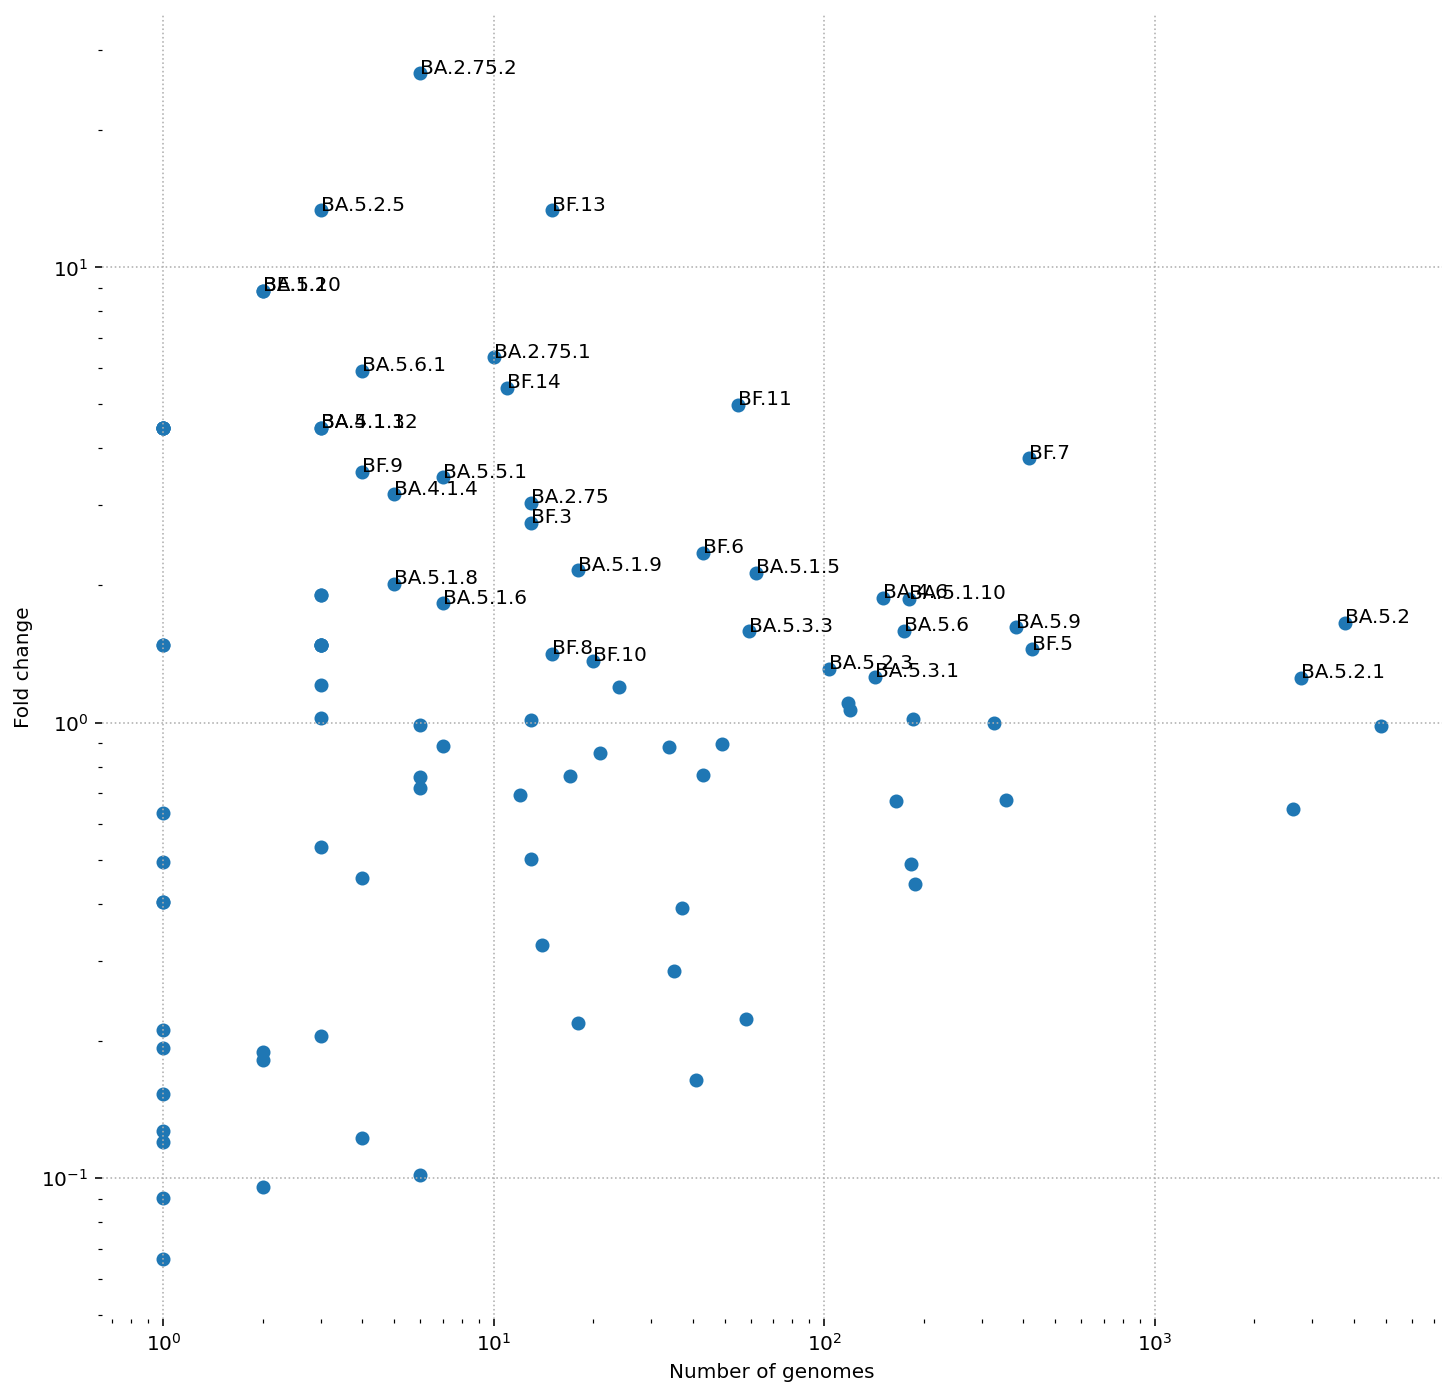

In [405]:
plt.figure(figsize=(12,12))
plt.scatter(n[f.index],f)
for l in f.index:
    if np.log(f[l]) > e[l]:
        plt.text(x=n[l], y=f[l], s=l)
plt.yscale('log')
plt.xlabel("Number of genomes")
plt.xscale('log')
plt.ylabel("Fold change")

(19083.0, 19235.0)

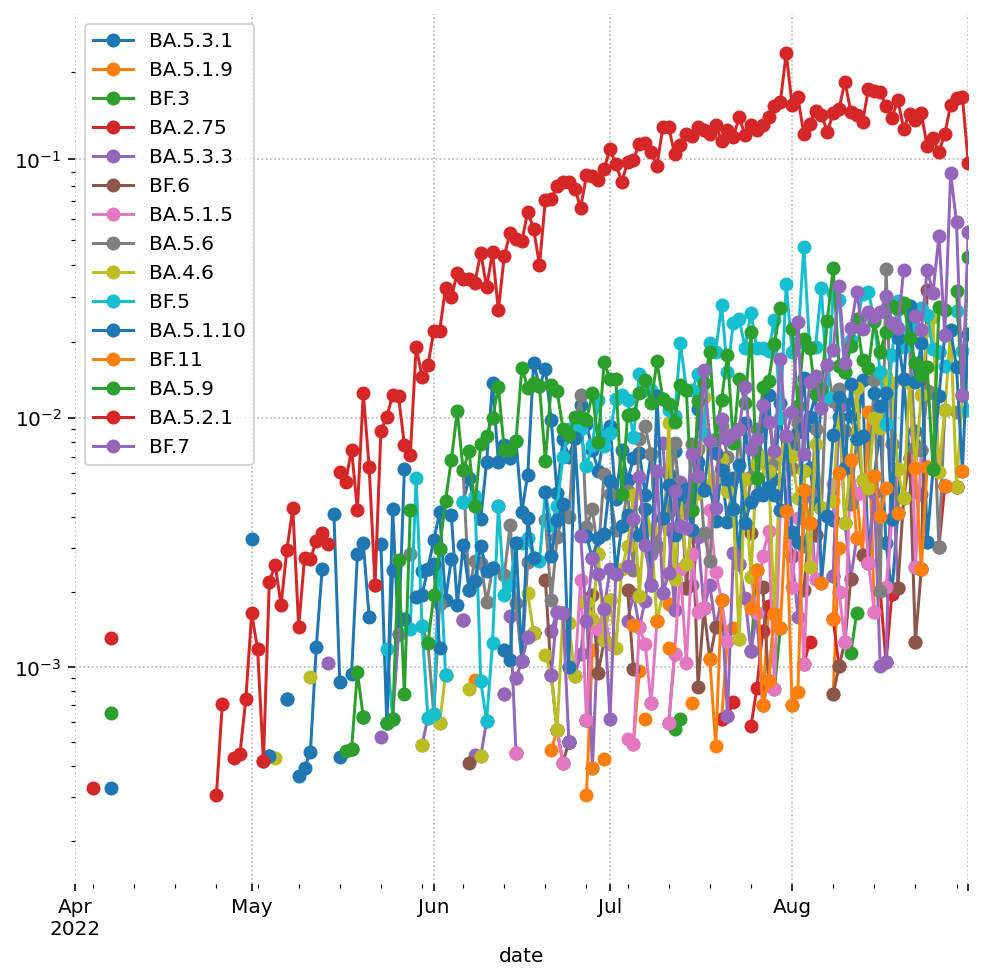

In [406]:
plt.figure(figsize=(8,8))
plt.set_cmap('tab20')
for i,v in enumerate((np.log(f)/e[f.index]).sort_values()[-20:-1].index.to_list() ):
    if g[v].sum()>=20:
        (g[v]/g.sum(1)+0).plot(label=v, ls="-", marker="o")
plt.yscale('logit')
#plt.show()
plt.legend()
plt.xlim(("2022-04-01",None))

In [407]:
genomes.loc["Sachsen", "2022-02-20"]["BA.4"] = 0 ## Remove outlier

In [408]:
genomes.index.levels[0]

Index(['Baden-Württemberg', 'Bayern', 'Berlin', 'Brandenburg', 'Bremen',
       'Hamburg', 'Hessen', 'Mecklenburg-Vorpommern', 'Niedersachsen',
       'Nordrhein-Westfalen', 'Rheinland-Pfalz', 'Saarland', 'Sachsen',
       'Sachsen-Anhalt', 'Schleswig-Holstein', 'Thüringen'],
      dtype='object', name='bundesland')

In [409]:
genomes.loc[:,"BA.2.75"].sum(level=0)

bundesland
Baden-Württemberg         11
Bayern                     3
Berlin                     2
Brandenburg                2
Bremen                     0
Hamburg                    0
Hessen                     0
Mecklenburg-Vorpommern     2
Niedersachsen              2
Nordrhein-Westfalen        1
Rheinland-Pfalz            1
Saarland                   1
Sachsen                    1
Sachsen-Anhalt             0
Schleswig-Holstein         1
Thüringen                  0
Name: BA.2.75, dtype: int64

In [410]:
G = genomes.values.reshape([len(genomes.index.levels[0]), len(genomes.index.levels[1]), -1])

In [411]:
lineages = genomes.columns.to_list()

In [412]:
G.sum((0,1))

array([ 19622,  89978,  15205,    324,     29,   3734,   5281,   8422,
        14169,    482,    682,     53,   1443,    106,    801,    260,
         1576,    868,    208,    389,     36,     50,     81,    193,
          979,   1594,    451,    775,    128,      4,     17,     20,
          214, 187921,  44508,     33,     34,     20,     44,      5,
           23,      2,      4,      3,      3,      6,      5,     22,
           33,   1155,   2491,    733,     50,    833,    584,    223,
          735,    552,   4857,    249,   3523,    690,     53,     33,
         1475,   1569,    206,    426,   1396,      6,     26,      3,
            1,    149,     30,     20,     46,      4,    218,     78,
           53,     39,     66,      4,     53,     27,    496,     14,
            4,     15,      7,     70,    173,     77,     42,    245,
          605,      7,    134,    215,    173,     42,      7,      3,
            8,      6,     48,      3,    228,     82,     27,     32,
      

In [413]:
pattern=re.compile(r"[A-Z]+(\.\d+)*$")
pattern.match(lineages[1])

<re.Match object; span=(0, 6), match='BA.1.1'>

In [414]:
vocs = ["BA.1","BA.1.1","BA.2","BA.4","BA.5","BA.2.12.1","BA.2.75", "BA.2.75.1","BA.2.75.2","BA.4.6", "BF.7", "BF.11", "BF.13"]

In [415]:
merged_lineages, G, _ = gs.preprocess_lineage_tensor(lineage_tensor=G, 
                                                     lineage_list=[alias(x, anti_alias=True) for x in lineages], 
                                                     vocs=[alias(x, anti_alias=True) for x in lineages if x in vocs], #any([y in x for y in ["BA.4","BA.5","BA.2.12.1"]])], 
                                                     cutoff=1000000)
merged_lineages

Dropped lineages []


['B.1.1.529',
 'B.1.1.529.1',
 'B.1.1.529.1.1',
 'B.1.1.529.2',
 'B.1.1.529.2.12.1',
 'B.1.1.529.2.75',
 'B.1.1.529.2.75.1',
 'B.1.1.529.2.75.2',
 'B.1.1.529.4',
 'B.1.1.529.4.6',
 'B.1.1.529.5',
 'B.1.1.529.5.2.1.7',
 'B.1.1.529.5.2.1.11',
 'B.1.1.529.5.2.1.13',
 'B.1.617.2',
 'Other']

In [416]:
baseline = 'B.1.617.2'
o = [merged_lineages.index(x) for x in merged_lineages if x != baseline] + [merged_lineages.index(baseline)]
G = G[:,:,o]
merged_lineages = [merged_lineages[x] for x in o]
merged_lineages

['B.1.1.529',
 'B.1.1.529.1',
 'B.1.1.529.1.1',
 'B.1.1.529.2',
 'B.1.1.529.2.12.1',
 'B.1.1.529.2.75',
 'B.1.1.529.2.75.1',
 'B.1.1.529.2.75.2',
 'B.1.1.529.4',
 'B.1.1.529.4.6',
 'B.1.1.529.5',
 'B.1.1.529.5.2.1.7',
 'B.1.1.529.5.2.1.11',
 'B.1.1.529.5.2.1.13',
 'Other',
 'B.1.617.2']

In [417]:
merged_lineages_alias = [alias(x) for x in merged_lineages]
merged_lineages_alias

['B.1.1.529',
 'BA.1',
 'BA.1.1',
 'BA.2',
 'BA.2.12.1',
 'BA.2.75',
 'BA.2.75.1',
 'BA.2.75.2',
 'BA.4',
 'BA.4.6',
 'BA.5',
 'BF.7',
 'BF.11',
 'BF.13',
 'Other',
 'B.1.617.2']

In [418]:
pd.DataFrame(G.reshape(-1,G.shape[2]), index=genomes.index, columns=merged_lineages_alias).sum()

B.1.1.529      1518.0
BA.1          57357.0
BA.1.1       109615.0
BA.2         259279.0
BA.2.12.1      3791.0
BA.2.75          28.0
BA.2.75.1        14.0
BA.2.75.2         6.0
BA.4           5979.0
BA.4.6          382.0
BA.5          89025.0
BF.7            703.0
BF.11            82.0
BF.13            17.0
Other          1523.0
B.1.617.2    119357.0
dtype: float64

In [419]:
with pd.option_context('display.max_rows', None,):
    print(pd.DataFrame(G.reshape(-1,G.shape[2]), index=genomes.index, columns=merged_lineages_alias).loc[:,"2022-02-20",:])

                        B.1.1.529   BA.1  BA.1.1   BA.2  BA.2.12.1  BA.2.75  \
bundesland                                                                    
Baden-Württemberg             2.0  111.0   374.0  431.0        0.0      0.0   
Bayern                        0.0    5.0    30.0   38.0        0.0      0.0   
Berlin                        0.0    2.0     0.0    6.0        0.0      0.0   
Brandenburg                   0.0    0.0     4.0    7.0        0.0      0.0   
Bremen                        0.0    0.0     0.0    0.0        0.0      0.0   
Hamburg                       0.0    0.0     0.0    0.0        0.0      0.0   
Hessen                        0.0    3.0     8.0   14.0        0.0      0.0   
Mecklenburg-Vorpommern        0.0    0.0     0.0    0.0        0.0      0.0   
Niedersachsen                 0.0    0.0     0.0    2.0        0.0      0.0   
Nordrhein-Westfalen           0.0   50.0    99.0  144.0        0.0      0.0   
Rheinland-Pfalz               0.0    3.0     0.0    

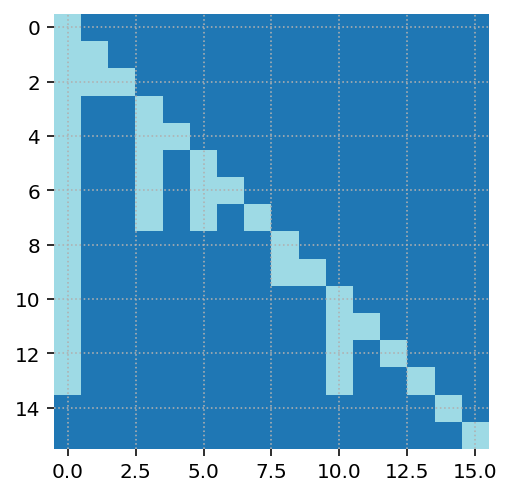

In [420]:
A = ancestor_matrix(merged_lineages)
plt.imshow(A)

### Cases
Also from RKI

In [421]:
cases_raw = pd.read_csv("https://media.githubusercontent.com/media/robert-koch-institut/SARS-CoV-2_Infektionen_in_Deutschland/master/Aktuell_Deutschland_SarsCov2_Infektionen.csv",  index_col=[0,1,2,4], parse_dates=True)

In [422]:
cases_raw

Meldedatum  \
IdLandkreis Altersgruppe Geschlecht Refdatum                 
1001        A15-A34      M          2020-01-19  2020-10-28   
                                    2020-03-13  2020-03-21   
                                    2020-03-13  2020-03-19   
                                    2020-03-16  2020-03-14   
                                    2020-03-16  2020-03-19   
...                                                    ...   
16077       A35-A59      W          2022-09-05  2022-09-05   
            A60-A79      W          2022-09-05  2022-09-05   
            A05-A14      W          2022-09-05  2022-09-05   
            A15-A34      W          2022-09-05  2022-09-05   
            A35-A59      W          2022-09-05  2022-09-05   

                                                IstErkrankungsbeginn  \
IdLandkreis Altersgruppe Geschlecht Refdatum                           
1001        A15-A34      M          2020-01-19                     1   
                                    2020-03-13                     1   
                                    2020-03-13                     1   
                                    2020-03-16                     1   
                                    2020-03-16                     1   
...                                                              ...   
16077       A35-A59      W          2022-09-05                     0   
            A60-A79      W          2022-09-05                     0   
            A05-A14      W          2022-09-05                     0   
            A15-A34      W          2022-09-05                     0   
            A35-A59      W          2022-09-05                     0   

                                                NeuerFall  NeuerTodesfall  \
IdLandkreis Altersgruppe Geschlecht Refdatum                                
1001        A15-A34      M          2020-01-19          0              -9   
                                    2020-03-13          0              -9   
                                    2020-03-13          0              -9   
                                    2020-03-16          0              -9   
                                    2020-03-16          0              -9   
...                                                   ...             ...   
16077       A35-A59      W          2022-09-05          0              -9   
            A60-A79      W          2022-09-05          1              -9   
            A05-A14      W          2022-09-05          1              -9   
            A15-A34      W          2022-09-05          1              -9   
            A35-A59      W          2022-09-05          1              -9   

                                                NeuGenesen  AnzahlFall  \
IdLandkreis Altersgruppe Geschlecht Refdatum                             
1001        A15-A34      M          2020-01-19           0           1   
                                    2020-03-13           0           1   
                                    2020-03-13           0           1   
                                    2020-03-16           0           1   
                                    2020-03-16           0           1   
...                                                    ...         ...   
16077       A35-A59      W          2022-09-05          -9           1   
            A60-A79      W          2022-09-05          -9           3   
            A05-A14      W          2022-09-05          -9           1   
            A15-A34      W          2022-09-05          -9           1   
            A35-A59      W          2022-09-05          -9           6   

                                                AnzahlTodesfall  AnzahlGenesen  
IdLandkreis Altersgruppe Geschlecht Refdatum                                    
1001        A15-A34      M          2020-01-19                0              1  
                                    2020-03-13                0              1  
               

### Registration delays

In [423]:
f = cases_raw.reset_index(level=3)[['Refdatum','Meldedatum','AnzahlFall'] ].reset_index()
f['Delta'] = np.clip(pd.to_datetime(f['Meldedatum']) - f['Refdatum'], np.timedelta64(0,"D"), np.timedelta64(10,"D"))
f['bundesland'] = (f.IdLandkreis/1000).astype("int")

f= f.set_index(["bundesland","IdLandkreis","Altersgruppe","Geschlecht","Refdatum","Delta"]).sum(level=[0,4,5]).sort_index()
f = f.unstack(level=2)["AnzahlFall"].sort_index().loc[:,"2022-02-01":,:]#.loc[:,"2021-11-01":]
f /= f.sum(1).values[:,np.newaxis]

<AxesSubplot:xlabel='bundesland,Refdatum'>

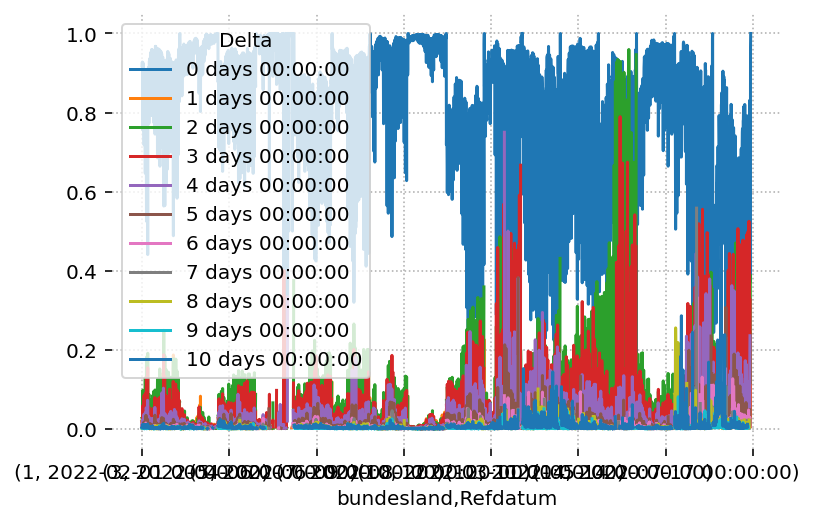

In [424]:
f.plot()

In [425]:
f['weekday'] = f.reset_index()['Refdatum'].dt.strftime("%a").values

In [426]:
f = f.reset_index().set_index(["bundesland","Refdatum","weekday"]).cumsum(1).mean(level=[0,2]).fillna(1)

In [427]:
f.loc[1]

Delta    0 days 00:00:00  1 days 00:00:00  2 days 00:00:00  3 days 00:00:00  \
weekday                                                                       
Tue             0.933329         0.952461         0.976288         0.988566   
Wed             0.930382         0.952568         0.976304         0.981993   
Thu             0.924836         0.948626         0.959041         0.964540   
Fri             0.915230         0.925597         0.937056         0.966467   
Sat             0.770048         0.791463         0.871707         0.944578   
Sun             0.684682         0.760041         0.878064         0.947150   
Mon             0.903661         0.929519         0.963781         0.981889   

Delta    4 days 00:00:00  5 days 00:00:00  6 days 00:00:00  7 days 00:00:00  \
weekday                                                                       
Tue             0.991246         0.991979         0.996102         0.997906   
Wed             0.983635         0.992158         0.996125         0.997870   
Thu             0.984092         0.993122         0.996525         0.997845   
Fri             0.985350         0.992949         0.995456         0.997151   
Sat             0.977347         0.987657         0.992123         0.993345   
Sun             0.973826         0.985683         0.986061         0.987290   
Mon             0.990730         0.992853         0.993132         0.996035   

Delta    8 days 00:00:00  9 days 00:00:00  10 days 00:00:00  
weekday                                                      
Tue             0.998494         0.998792               1.0  
Wed             0.998538         0.999014               1.0  
Thu             0.998464         0.998371               1.0  
Fri             0.997458         0.996509               1.0  
Sat             0.993528         0.996253               1.0  
Sun             0.992809         0.995258               1.0  
Mon             0.997292         0.998212               1.0

In [428]:
reporting_lag = np.array([f.loc[:,d.strftime("%a"),:].iloc[:,(cases_raw.index.levels[3][-1]-d).days] for d in cases_raw.index.levels[3][-9:]]).T

In [429]:
s="""01  Schleswig-Holstein
02  Hamburg
03  Niedersachsen
04  Bremen
05  Nordrhein-Westfalen
06  Hessen
07  Rheinland-Pfalz
08  Baden-Württemberg
09  Bayern
10  Saarland
11  Berlin
12  Brandenburg
13  Mecklenburg-Vorpommern
14  Sachsen
15  Sachsen-Anhalt
16  Thüringen"""
b={int(x.split()[0]): x.split()[1] for x in s.split("\n")}

In [430]:
current_lag = pd.DataFrame(reporting_lag, index=np.arange(1,17)).rename(index=b).sort_index()
current_lag

0         1         2         3         4  \
Baden-Württemberg       0.999663  0.999644  0.999338  0.998476  0.997807   
Bayern                  0.992926  0.992688  0.987903  0.976552  0.954298   
Berlin                  0.987375  0.985463  0.982532  0.970493  0.950247   
Brandenburg             0.990971  0.991825  0.989641  0.980668  0.970038   
Bremen                  0.998807  0.999035  0.998645  0.998297  0.995038   
Hamburg                 0.997524  0.997244  0.997197  0.995925  0.991875   
Hessen                  0.998133  0.998039  0.996375  0.992223  0.989239   
Mecklenburg-Vorpommern  0.996134  0.997379  0.996151  0.992001  0.985140   
Niedersachsen           0.994508  0.995216  0.993462  0.989029  0.980205   
Nordrhein-Westfalen     0.994803  0.994104  0.990639  0.982414  0.967872   
Rheinland-Pfalz         0.997952  0.998640  0.997391  0.992469  0.990660   
Saarland                0.993610  0.996796  0.994962  0.985260  0.985056   
Sachsen                 0.998359  0.998631  0.997193  0.994041  0.986633   
Sachsen-Anhalt          0.983174  0.971637  0.973677  0.975115  0.937525   
Schleswig-Holstein      0.997292  0.997906  0.996125  0.993122  0.985350   
Thüringen               0.962473  0.962477  0.958509  0.929756  0.881287   

                               5         6         7         8  
Baden-Württemberg       0.991190  0.975789  0.991090  0.993359  
Bayern                  0.869988  0.735579  0.795160  0.810182  
Berlin                  0.799908  0.551394  0.887751  0.897455  
Brandenburg             0.877775  0.685297  0.917812  0.941257  
Bremen                  0.987262  0.889682  0.990301  0.993417  
Hamburg                 0.981318  0.969649  0.975905  0.975860  
Hessen                  0.953308  0.864596  0.937849  0.937043  
Mecklenburg-Vorpommern  0.912274  0.835232  0.768300  0.838236  
Niedersachsen           0.943153  0.853989  0.921749  0.940126  
Nordrhein-Westfalen     0.915942  0.812289  0.870176  0.864291  
Rheinland-Pfalz         0.950237  0.878564  0.963909  0.975135  
Saarland                0.823359  0.708967  0.850702  0.939706  
Sachsen                 0.957134  0.894593  0.942761  0.945180  
Sachsen-Anhalt          0.726488  0.596133  0.813537  0.860735  
Schleswig-Holstein      0.944578  0.878064  0.929519  0.933329  
Thüringen               0.759167  0.516020  0.697347  0.700627

In [431]:
cases = cases_raw['AnzahlFall'].sum(level=(0,3)).sort_index()

In [432]:
cases_land = cases.reset_index()
cases_land['bundesland'] = (cases_land.IdLandkreis/1000).astype("int")
cases_land = cases_land.set_index(['bundesland', 'IdLandkreis','Refdatum']).sum(level=(0,2)).sort_index()
cases_land = cases_land.rename(index=b).sort_index()
cases_land = cases_land.loc[:,"2021-11-01":,:].unstack()["AnzahlFall"]#.iloc[:,:-1]
#cases_land.iloc[:,-9:] = (cases_land.iloc[:,-9:] / reporting_lag).astype("int32")
cases_land

Refdatum                2021-11-01  2021-11-02  2021-11-03  2021-11-04  \
bundesland                                                               
Baden-Württemberg             2149        2966        4411        4616   
Bayern                        6076        7183        9051        8903   
Berlin                        1326        1321        1443        1435   
Brandenburg                    857         957        1070        1076   
Bremen                          79          89          69          62   
Hamburg                        334         461         525         502   
Hessen                        1195        1597        1706        1575   
Mecklenburg-Vorpommern         418         428         405         317   
Niedersachsen                 1189        1458        1674        1369   
Nordrhein-Westfalen           2577        3476        4367        4343   
Rheinland-Pfalz                651         996        1130        1060   
Saarland                       127         123         203         230   
Sachsen                       2848        3678        3490        3325   
Sachsen-Anhalt                 647         858         723         740   
Schleswig-Holstein             337         389         370         354   
Thüringen                     1825        1431        1428        1508   

Refdatum                2021-11-05  2021-11-06  2021-11-07  2021-11-08  \
bundesland                                                               
Baden-Württemberg             5065        4129        2280        4393   
Bayern                        9215        8673        7312        9408   
Berlin                        1452         970         759        2177   
Brandenburg                   1212        1157        1022        1324   
Bremen                          55          55          32          60   
Hamburg                        558         458         409         489   
Hessen                        1689        1312        1093        1470   
Mecklenburg-Vorpommern         543         504         314         528   
Niedersachsen                 1405        1165         848        1622   
Nordrhein-Westfalen           4081        3709        2969        4454   
Rheinland-Pfalz               1029         799         770        1077   
Saarland                       185         214         155         209   
Sachsen                       3465        3209        2697        4476   
Sachsen-Anhalt                 729         652         900         671   
Schleswig-Holstein             435         383         298         449   
Thüringen                     1436        1767        1200        1872   

Refdatum                2021-11-09  2021-11-10  ...  2022-08-28  2022-08-29  \
bundesland                                      ...                           
Baden-Württemberg             7127        7755  ...         453        4171   
Bayern                       11237       11947  ...        1585        6728   
Berlin                        1915        2404  ...         204        1307   
Brandenburg                   1496        1702  ...          86        1291   
Bremen                         143          95  ...           4         404   
Hamburg                        540         565  ...         279         474   
Hessen                        1792        2022  ...         494        4465   
Mecklenburg-Vorpommern         597         468  ...         240         983   
Niedersachsen                 1753        2165  ...         530        4694   
Nordrhein-Westfalen           5190        5313  ...        2930       10725   
Rheinland-Pfalz               1138        1328  ...         145        2912   
Saarland                       273         301  ...          23         624   
Sachsen                       5757        5989  ...         246        2167   
Sachsen-Anhalt                1018        1177  ...         192         915   
Schleswig-Holstein             487         542  ...         372       

In [433]:
cases_land.sum(0)

Refdatum
2021-11-01    22635
2021-11-02    27411
2021-11-03    32065
2021-11-04    31415
2021-11-05    32554
              ...  
2022-09-02    26816
2022-09-03     7967
2022-09-04     4491
2022-09-05    37180
2022-09-06    29855
Length: 310, dtype: int64

In [434]:
clip = 2
cases_land.iloc[:,-9:] = (cases_land.iloc[:,-9:] / current_lag.values)#.astype("int32")
cases_land.loc["Hamburg"].iloc[-2:] = np.nan
cases_land = cases_land.iloc[:,:cases_land.shape[1]-clip]
cases_land

/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Refdatum                2021-11-01  2021-11-02  2021-11-03  2021-11-04  \
bundesland                                                               
Baden-Württemberg             2149        2966        4411        4616   
Bayern                        6076        7183        9051        8903   
Berlin                        1326        1321        1443        1435   
Brandenburg                    857         957        1070        1076   
Bremen                          79          89          69          62   
Hamburg                        334         461         525         502   
Hessen                        1195        1597        1706        1575   
Mecklenburg-Vorpommern         418         428         405         317   
Niedersachsen                 1189        1458        1674        1369   
Nordrhein-Westfalen           2577        3476        4367        4343   
Rheinland-Pfalz                651         996        1130        1060   
Saarland                       127         123         203         230   
Sachsen                       2848        3678        3490        3325   
Sachsen-Anhalt                 647         858         723         740   
Schleswig-Holstein             337         389         370         354   
Thüringen                     1825        1431        1428        1508   

Refdatum                2021-11-05  2021-11-06  2021-11-07  2021-11-08  \
bundesland                                                               
Baden-Württemberg             5065        4129        2280        4393   
Bayern                        9215        8673        7312        9408   
Berlin                        1452         970         759        2177   
Brandenburg                   1212        1157        1022        1324   
Bremen                          55          55          32          60   
Hamburg                        558         458         409         489   
Hessen                        1689        1312        1093        1470   
Mecklenburg-Vorpommern         543         504         314         528   
Niedersachsen                 1405        1165         848        1622   
Nordrhein-Westfalen           4081        3709        2969        4454   
Rheinland-Pfalz               1029         799         770        1077   
Saarland                       185         214         155         209   
Sachsen                       3465        3209        2697        4476   
Sachsen-Anhalt                 729         652         900         671   
Schleswig-Holstein             435         383         298         449   
Thüringen                     1436        1767        1200        1872   

Refdatum                2021-11-09  2021-11-10  ...  2022-08-26  2022-08-27  \
bundesland                                      ...                           
Baden-Württemberg             7127        7755  ...        2640         965   
Bayern                       11237       11947  ...        4190        1841   
Berlin                        1915        2404  ...        1662         295   
Brandenburg                   1496        1702  ...        1022         183   
Bremen                         143          95  ...         312          63   
Hamburg                        540         565  ...         523         212   
Hessen                        1792        2022  ...        2281         705   
Mecklenburg-Vorpommern         597         468  ...         828         183   
Niedersachsen                 1753        2165  ...        3902         821   
Nordrhein-Westfalen           5190        5313  ...        8638        3792   
Rheinland-Pfalz               1138        1328  ...        1160         168   
Saarland                       273         301  ...         350          15   
Sachsen                       5757        5989  ...        1403         389   
Sachsen-Anhalt                1018        1177  ...         683         256   
Schleswig-Holstein             487         542  ...        1159       

In [435]:
C = cases_land.values

### Population data
From Destatis

In [436]:
capita = pd.read_csv("data/12411-0010.csv", index_col=0)["Population"]
capita

Baden-Württemberg         11103043
Bayern                    13140183
Berlin                     3664088
Brandenburg                2531071
Bremen                      680130
Hamburg                    1852478
Hessen                     6293154
Mecklenburg-Vorpommern     1610774
Niedersachsen              8003421
Nordrhein-Westfalen       17925570
Rheinland-Pfalz            4098391
Saarland                    983991
Sachsen                    4056941
Sachsen-Anhalt             2180684
Schleswig-Holstein         2910875
Thüringen                  2120237
Name: Population, dtype: int64

In [437]:
131 % 10

1

## Modeling
### Basis functions

In [438]:
from genomicsurveillance.misc import fused_basis
n = C.shape[1]+clip 
inc = 10
B0 = fused_basis(n+2, inc=inc, fuse=5, pad=35 - n % inc) ## cubic spline basis every 10d, last 4 linearly fused to avoid wriggles 
#B0 = fused_basis(n+2, inc=7, fuse=5, pad=30 - n % 7)## cubic spline basis every 7d, last 5 linearly fused to avoid wriggles 
B0 = np.stack([B0[0,2:,:],B0[1,:-2,:]])
#B0 = B0[:,:-(inc-n%inc)][:,-n:]

In [439]:
B0.shape

(2, 310, 34)

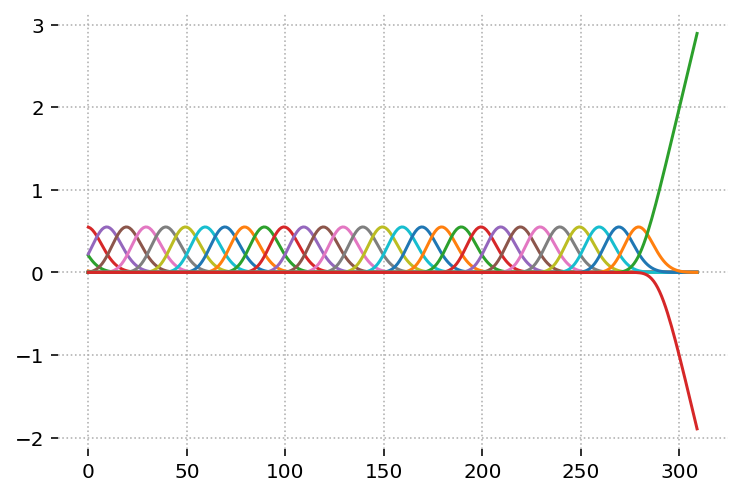

In [440]:
for i in range(B0.shape[-1]):
    plt.plot(B0[0,:,i])

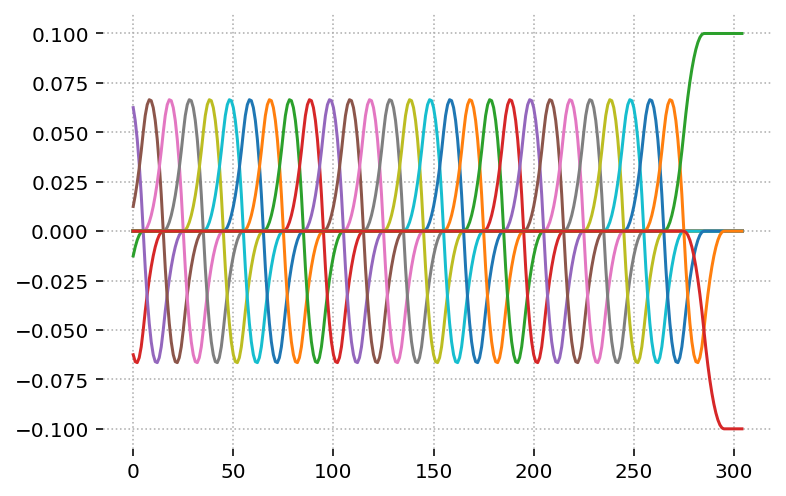

In [441]:
for i in range(B0.shape[-1]):
    plt.plot(B0[1,:-5,i])

In [442]:
np.sum(np.diff(B0[1,-30:,-1])+1 == 1)

14

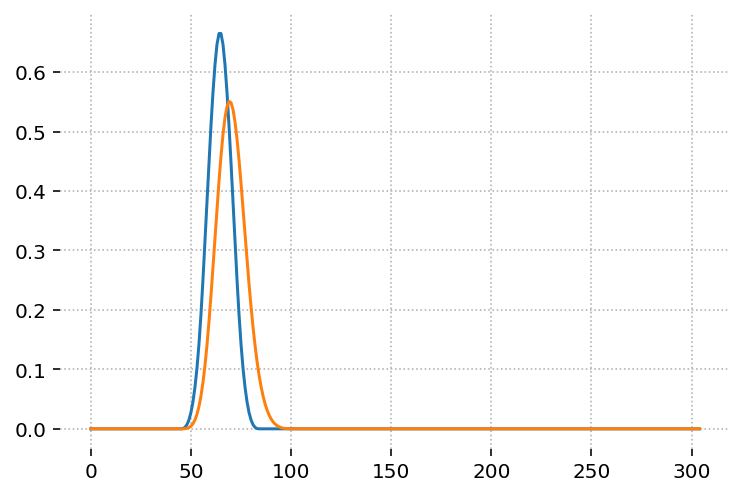

In [443]:
plt.plot(B0[1,:-5,10].cumsum())
plt.plot(B0[0,:-5,10])


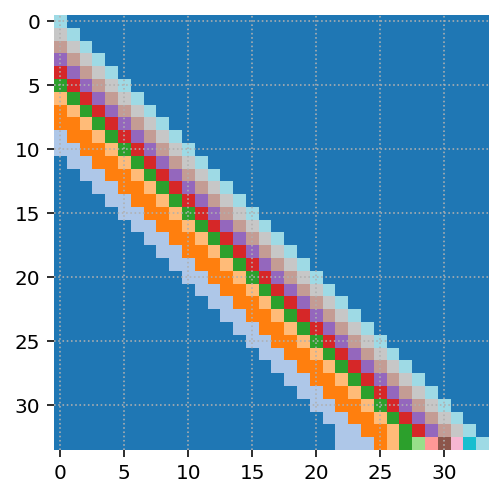

In [444]:
arma2 = np.eye(B0.shape[-1]) ## Prior covariance matrix for the splines to avoid too many wrinkles
for j in range(arma2.shape[0]-1):
    arma2[j+1,j] = -0.75
arma2[-1,-2] = -.9
arma2 = np.linalg.inv(arma2)
plt.imshow(arma2)

### Case and genome data
Prepare as arrays and add Germany as a whole

In [445]:
seq_index = np.array([list(cases_land.columns).index(i) for i in genomes.index.levels[1]])

In [571]:
import importlib
importlib.reload(gs.misc.misc)
importlib.reload(gs.misc)
from genomicsurveillance.misc import MultiLineageTimeShift, plot_lad, plot_growth_rates, alias

In [542]:
from numpyro.infer import Trace_ELBO

In [543]:
GG = np.concatenate([G, G.sum(0, keepdims=True)], axis=0) # Add Germany as a whole
CC = np.concatenate([C, C.sum(0, keepdims=True)], axis=0)    

In [544]:
CC[2,cases_land.columns == np.datetime64("2022-03-08")] = np.nan # int women's day in Berlin..
#GG[-1, genomes.index.levels[1] <= "2022-07-15", merged_lineages_alias.index("BA.2.75")] = 0

In [545]:
f = pd.DataFrame(GG.sum(1).astype("int"), index=cases_land.index.to_list() + ["Germany"], columns=[alias(x) for x in merged_lineages])

In [546]:
f

B.1.1.529   BA.1  BA.1.1    BA.2  BA.2.12.1  BA.2.75  \
Baden-Württemberg             242  14039   29277   52067        572       12   
Bayern                        108   3848    9121   32951        543        3   
Berlin                         13    701    1085    4317         78        2   
Brandenburg                    11    907    1658    5567        118        2   
Bremen                         13    328     893    2694         15        0   
Hamburg                        96   4204    4460   11406        106        0   
Hessen                         23   1086    1992    3533         54        0   
Mecklenburg-Vorpommern         65    738    1013    3303         55        2   
Niedersachsen                  15    958    1664    8384        159        2   
Nordrhein-Westfalen           595  18032   35225   76361       1185        1   
Rheinland-Pfalz                 8    453     881    4079        105        1   
Saarland                       46   1116    2205    4923         38        1   
Sachsen                       222   6262   11642   23542        254        1   
Sachsen-Anhalt                  8    763    1834    3265         51        0   
Schleswig-Holstein             26   3440    5426   20987        436        1   
Thüringen                      27    482    1239    1900         22        0   
Germany                      1518  57357  109615  259279       3791       28   

                        BA.2.75.1  BA.2.75.2  BA.4  BA.4.6   BA.5  BF.7  \
Baden-Württemberg               8          3  1292     133  19680   202   
Bayern                          0          2   607      22   7892    45   
Berlin                          1          0   145      12   2386    16   
Brandenburg                     1          0   156       6   2907    15   
Bremen                          0          0    86       6   1021    14   
Hamburg                         0          1   224      10   2467    22   
Hessen                          0          0    44       2    858     4   
Mecklenburg-Vorpommern          0          0    94       8   1933    19   
Niedersachsen                   0          0   275      25   5200    49   
Nordrhein-Westfalen             2          0  1313      66  20672   146   
Rheinland-Pfalz                 0          0   129       4   2017    16   
Saarland                        0          0   157      10   2253    14   
Sachsen                         0          0   429      30   7300    44   
Sachsen-Anhalt                  0          0    41       4    959     5   
Schleswig-Holstein              2          0   956      43  10849    88   
Thüringen                       0          0    31       1    631     4   
Germany                        14          6  5979     382  89025   703   

                        BF.11  BF.13  Other  B.1.617.2  
Baden-Württemberg          57      6    198      41431  
Bayern                      0      0    124       6256  
Berlin                      4      0     45       2898  
Brandenburg                 0      0     43       2852  
Bremen                      1      0      9        837  
Hamburg                     0      2    102       3787  
Hessen                      1      0     12       1645  
Mecklenburg-Vorpommern      5      0     20       2865  
Niedersachsen               1      2     40       3022  
Nordrhein-Westfalen         3      2    522      26488  
Rheinland-Pfalz             0      0     17       1517  
Saarland                    0      0     14       1779  
Sachsen                     3      1    129      15349  
Sachsen-Anhalt              1      0     33       2999  
Schleswig-Holstein          6      4    210       3914  
Thüringen                   0      0      5       1718  
Germany                    82     17   1523     119357

### Model
Multi-lineage model with variable growth rates (random effect) across states

In [572]:
model = MultiLineageTimeShift(
    CC[[-1]],
    GG[[-1]],    
    seq_index,
    np.concatenate([capita.values, capita.values.sum().reshape(1)])[[-1]],
    #auto_correlation=0.5,
    #linearize=True,
    arma = arma2,
    #b_scale=0.01,
    b0_scale=0.3,
    #c_scale=30,
    c0_scale=30,
    #c0_loc=-10,
    beta_scale= np.append(10.,np.repeat(10., B0.shape[2]-1)),# np.concatenate([np.repeat(1., knots.num_long_basis), np.repeat(.1, knots.num_short_basis)]),
    tau=4.6,
    basis=B0, #knots.basis,
    shift=7,  
    alpha0=.001,#.001,
    alpha1=1000., 
    week=True,
    fit_logits=True,
    ancestor_matrix=A,
    #model_kwargs={'handler':'SVI', 'loss':Trace_ELBO(num_particles=5), 'num_epochs':10000, 'lr':0.001, 'num_samples': 100}
    #model_kwargs={'handler':'SVI', 'loss':Trace_ELBO(num_particles=10), 'num_epochs':10000, 'lr':0.005, 'lrd': 0.1 ** (1/10000), 'num_samples': 100}
    model_kwargs={'handler':'SVI', 'loss':Trace_ELBO(num_particles=100), 'num_epochs':2000, 'lr':0.05, 'lrd': 0.1 ** (1/2000), 'num_samples': 100, 'log_freq':200}

)

In [573]:
model.fit()

/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/jax/_src/numpy/lax_numpy.py:6576: UserWarning: Explicitly requested dtype float requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


SVI step 0 / 2,000 | 0 %
SVI step 200 / 2,000 | 10 %
SVI step 400 / 2,000 | 20 %
SVI step 600 / 2,000 | 30 %
SVI step 800 / 2,000 | 40 %
SVI step 1,000 / 2,000 | 50 %
SVI step 1,200 / 2,000 | 60 %
SVI step 1,400 / 2,000 | 70 %
SVI step 1,600 / 2,000 | 80 %
SVI step 1,800 / 2,000 | 90 %


Text(0, 0.5, 'ELBO')

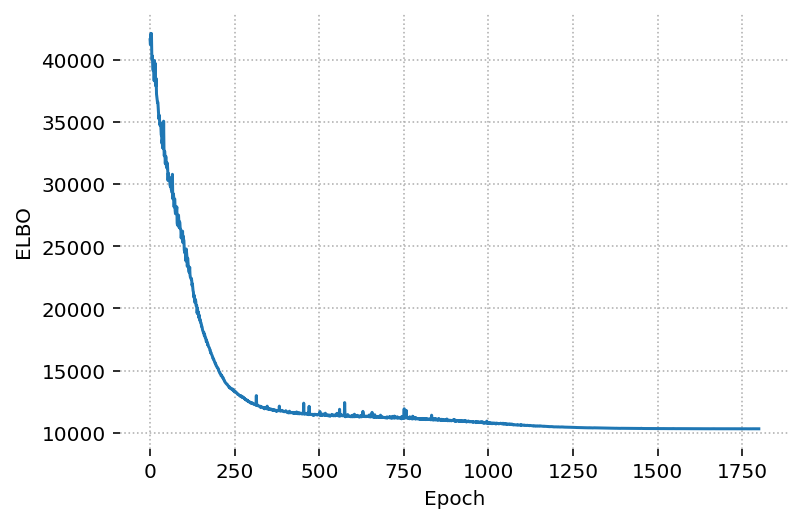

In [574]:
plt.plot(model.loss[200:])
plt.xlabel('Epoch')
plt.ylabel('ELBO')

Text(0, 0.5, 'ELBO')

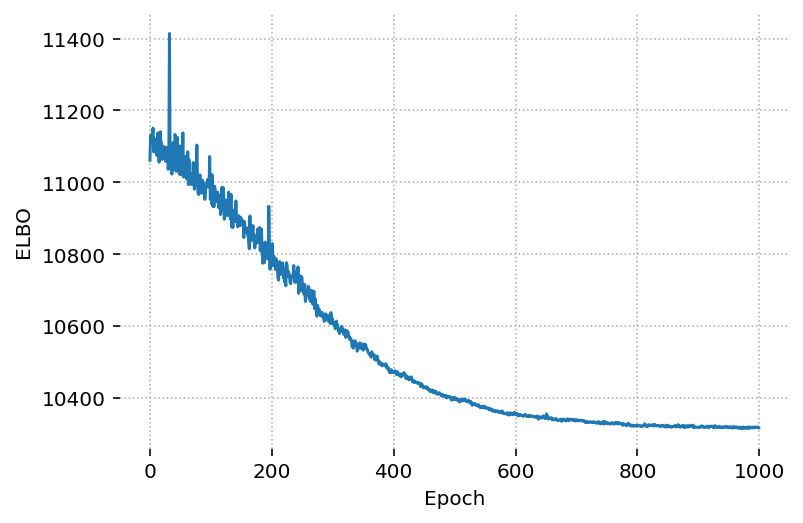

In [575]:
plt.plot(model.loss[1000:])
plt.xlabel('Epoch')
plt.ylabel('ELBO')

In [576]:
model.fit()

/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/jax/_src/numpy/lax_numpy.py:6576: UserWarning: Explicitly requested dtype float requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


SVI step 0 / 2,000 | 0 %
SVI step 200 / 2,000 | 10 %
SVI step 400 / 2,000 | 20 %
SVI step 600 / 2,000 | 30 %
SVI step 800 / 2,000 | 40 %
SVI step 1,000 / 2,000 | 50 %
SVI step 1,200 / 2,000 | 60 %
SVI step 1,400 / 2,000 | 70 %
SVI step 1,600 / 2,000 | 80 %
SVI step 1,800 / 2,000 | 90 %


Text(0, 0.5, 'ELBO')

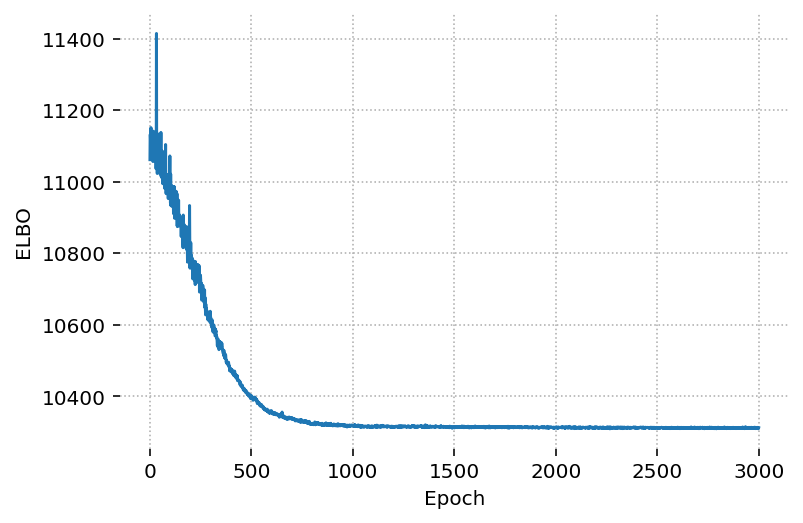

In [577]:
plt.plot(model.loss[1000:])
plt.xlabel('Epoch')
plt.ylabel('ELBO')
#plt.ylim((model.loss[2000],model.loss[1200]))

In [553]:
lineage_colors = {'B.1.1.529':'C7',
                 'BA.1': 'C3',#'mistyrose', #
                 'BA.1.1': 'C4',#"lavender", #
                 'BA.2':"C1", 
                 'BA.2.12.1':"C6",
                 'BA.2.75':"orangered",
                  'BA.2.75.1':"salmon",
                  'BA.2.75.2':"lightsalmon",
                 'BA.4':"C8",
                 'BA.4.6': 'peru',
                 'BA.5':"C9",
                  "BF.7":"limegreen",
                  'BF.11':"C2",
                  'BF.13':"yellowgreen",
                 'Other':"C7",
                 'B.1.617.2': 'C0'} #"aliceblue"}

In [554]:
merged_lineages_alias = [alias(x) for x in merged_lineages]

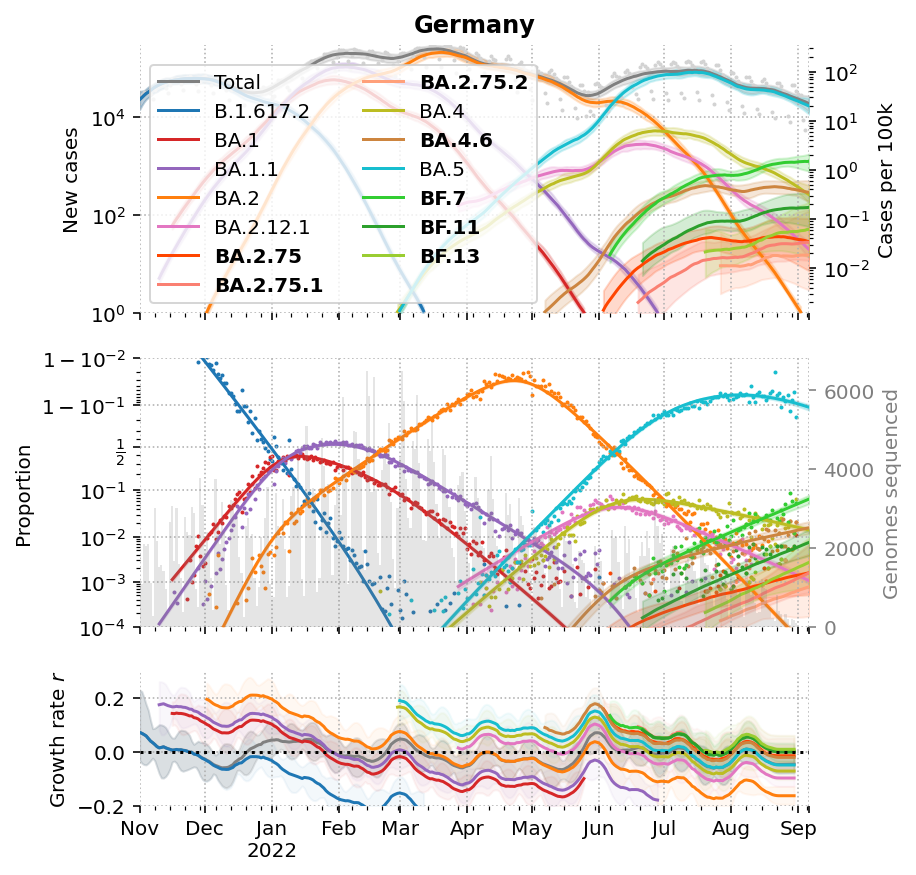

In [555]:
#from genomicsurveillance.plots.england import plot_lad, 
plt.rcParams['font.sans-serif'] = ["DejaVu Sans"]
from matplotlib import gridspec
from genomicsurveillance.plots.england import plot_median_and_ci
#from matplotlib import rc
#rc('text', usetex=False)
for i,r in [(-1, "Germany")]:#enumerate(cases_land.index.to_list() + ["Germany"]):
    w = np.where(GG[i].sum(0) >= 3)[0]
    w = list(set(w) - set([0,GG.shape[2]-2]))
    w = [w[-1]] + w[:-1]
    #plt.set_cmap("tab20")
    col = [lineage_colors[x] for x in merged_lineages_alias]
    plot_lad(model, i, CC, GG, seq_index, start_date="2021-11-01", show_start_date="2021-11-01",
        lin = w,
        labels = np.array(merged_lineages_alias)[w], #[x if not x in ["BA.2.75", "BA.4.6","BA.5.2.1.7","BA.5.2.1.11"] else r"$\bf{"+x+"}$" for x in merged_lineages_alias])[w],#genomes.columns[w],
        #lin_colors=np.array(5*['C7','C3',"C4","C1", "C6","C8" ,"C9", "C7","C0"])[w],#, "C6", "C1","C8"],
        lin_colors=np.array(5*col)[w],#, "C6", "C1","C8"],
        #labels=[alias(y) if alias(y) != "AY.121" else "Orf3a:202L" for y in x],#["B.1.1.7", 'Delta', "AY.4", 'B.1.617.2.5', "B.1.177"],
        case_color="grey",
        case_markercolor="lightgrey",
             lin_marker=".",
             lin_marker_size=2,
            figsize=(5,6),
            prop_err=False,
            show_Rt=False)

    ax=plt.gcf().get_axes()
    
    ax[0].set_title(r, size=12, weight='bold')
    ax[0].set_yscale('log')
    ax[0].set_ylim((1,None))
   
    #ax[1].grid(which='both', ls=":")
    #ax[0].legend(loc='center left')
    #ax[2].set_ylim((-0.2,0.3))
    #ax[3].grid(False)
    
    #for a in ax:
        #a.xaxis.set_major_formatter(pd.plotting._matplotlib.converter.TimeSeries_DateFormatter("D"))
        #for s in a.spines:
        #    a.spines[s].set_visible(True)
    #fig = plt.gcf()
    #plt.tight_layout()
    ax[0].set_ylim((None, np.nanmax(CC[i,:])))
    ax[1].set_yscale("logit")
    ax[1].set_ylim((1e-4,1-1e-2))
    ax[2].set_ylim((-.2,.3))
    ax[1].get_legend().remove()
    ax[2].get_legend().remove()
    for i in range(3):
        ax[i].set_position(gridspec.GridSpec(3, 1, height_ratios=[1,1, 0.5])[i].get_position(plt.gcf()))
    #ax[2].legend(loc="upper left")
    ax[2].axhline(0, color='k', ls=":")
    leg = ax[0].legend(loc="lower left", ncol=2)
    for l in leg.get_texts():
        if re.match("|".join(["BA.2.75", "BA.4.6","BF"]),l.get_text()):
            l.set_weight('bold')
    plt.gcf().set_size_inches(6,7)

In [578]:
b = np.array(model.posterior['b1'])
b[b==0] = np.nan
b[...,-1]= 0
r = pd.DataFrame((b - b[...,[1]]).mean((0,2)), columns=merged_lineages_alias, index=["Germany"])# cases_land.index.to_list() + ["Germany"])

In [579]:
r

B.1.1.529  BA.1   BA.1.1      BA.2  BA.2.12.1   BA.2.75  BA.2.75.1  \
Germany   0.057681   0.0  0.02507  0.093251     0.1546  0.238236   0.263065   

         BA.2.75.2      BA.4    BA.4.6     BA.5     BF.7    BF.11     BF.13  \
Germany   0.252401  0.181451  0.231509  0.20374  0.25261  0.25835  0.274731   

            Other  B.1.617.2  
Germany  0.107847   -0.13587

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]),
 [Text(1, 0, 'B.1.1.529'),
  Text(2, 0, 'BA.1'),
  Text(3, 0, 'BA.1.1'),
  Text(4, 0, 'BA.2'),
  Text(5, 0, 'BA.2.12.1'),
  Text(6, 0, 'BA.2.75'),
  Text(7, 0, 'BA.2.75.1'),
  Text(8, 0, 'BA.2.75.2'),
  Text(9, 0, 'BA.4'),
  Text(10, 0, 'BA.4.6'),
  Text(11, 0, 'BA.5'),
  Text(12, 0, 'BF.7'),
  Text(13, 0, 'BF.11'),
  Text(14, 0, 'BF.13'),
  Text(15, 0, 'Other'),
  Text(16, 0, 'B.1.617.2')])

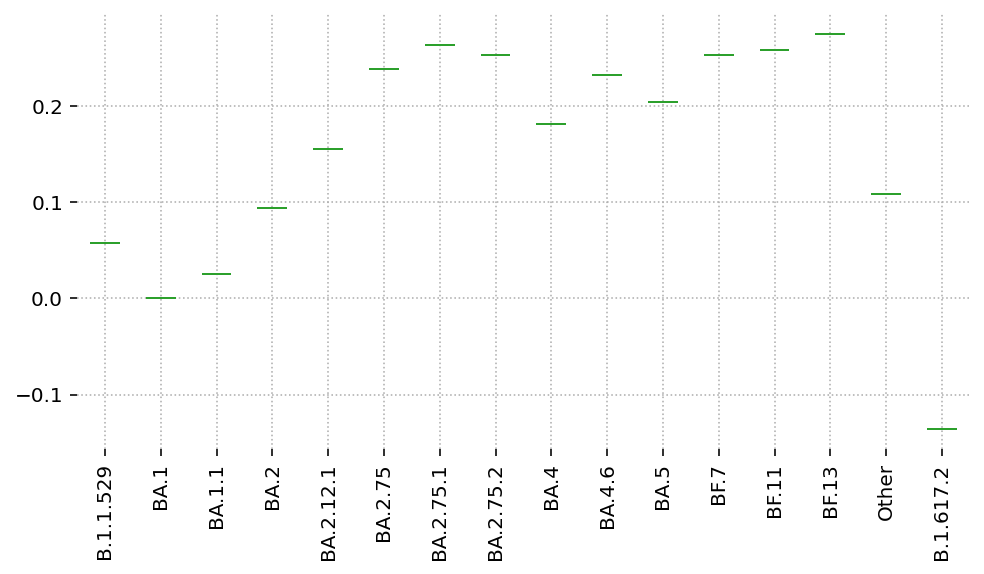

In [580]:
#r[r==0] = np.nan
plt.figure(figsize=(8,4))
r.boxplot(figsize=(8,4))
plt.xticks(rotation=90)
#r.mean(0).plot(ls="", marker=".")


In [581]:
import re

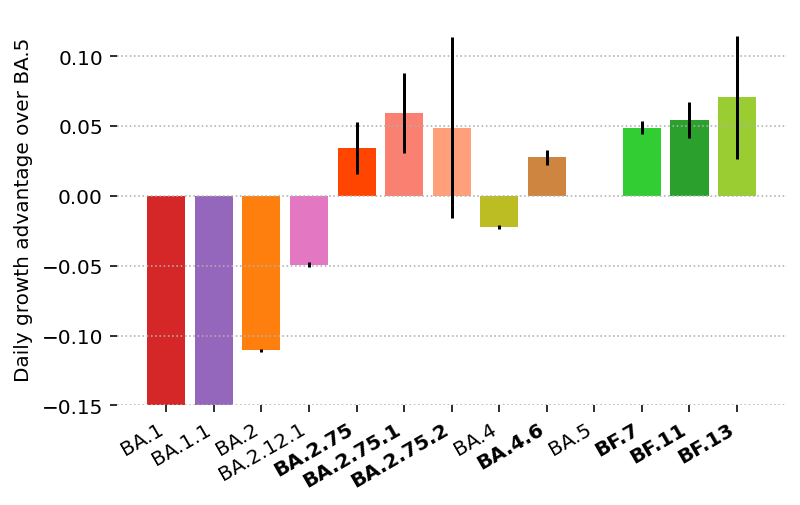

[Text(0, 0, 'BA.1'), Text(1, 0, 'BA.1.1'), Text(2, 0, 'BA.2'), Text(3, 0, 'BA.2.12.1'), Text(4, 0, 'BA.2.75'), Text(5, 0, 'BA.2.75.1'), Text(6, 0, 'BA.2.75.2'), Text(7, 0, 'BA.4'), Text(8, 0, 'BA.4.6'), Text(9, 0, 'BA.5'), Text(10, 0, 'BF.7'), Text(11, 0, 'BF.11'), Text(12, 0, 'BF.13')]


In [582]:
baseline = "BA.5"
s = pd.DataFrame((b - b[...,[merged_lineages_alias.index(baseline)]]).mean((2))[:,-1], columns=merged_lineages_alias).iloc[:,1:-2]
#s.boxplot()
plt.figure(figsize=(6,4))
plt.bar(s.columns, s.iloc[:-1,:].mean(), yerr=2*s.std(), color=[lineage_colors[x] for x in s.columns])
#plt.ylim((-0.15,0.2))
plt.ylim((-0.15,None))
#plt.draw()
#lt.xticks(rotation=45)
plt.ylabel(f"Daily growth advantage over {baseline}")
plt.grid(False)
plt.grid(axis="y")
plt.gcf().autofmt_xdate()
plt.draw()
xl = plt.gca().get_xticklabels()
for l in xl:
    if re.match("|".join(["BA.2.75", "BA.4.6","BF"]),l.get_text()):
        l.set_weight('bold')
plt.show()
print(xl)

In [560]:
q=(0.025,0.5,0.975)
pd.DataFrame(np.quantile(model.get_probabilities()[:,0,-1:,:], q, 0).squeeze(), index=np.array(q), columns=merged_lineages_alias)

B.1.1.529          BA.1        BA.1.1      BA.2  BA.2.12.1  \
0.025  3.646710e-11  7.110349e-14  3.096003e-11  0.000027   0.000898   
0.500  8.788114e-11  8.657094e-14  3.608620e-11  0.000030   0.001049   
0.975  2.281880e-10  1.109283e-13  4.379730e-11  0.000035   0.001279   

        BA.2.75  BA.2.75.1  BA.2.75.2      BA.4    BA.4.6      BA.5      BF.7  \
0.025  0.000510   0.000578   0.000169  0.012408  0.011588  0.869938  0.052316   
0.500  0.001587   0.001579   0.000778  0.014060  0.015800  0.886235  0.065693   
0.975  0.004130   0.006521   0.006894  0.015937  0.021644  0.899476  0.078961   

          BF.11     BF.13         Other     B.1.617.2  
0.025  0.003801  0.000742  4.666217e-07  3.373476e-28  
0.500  0.007537  0.002715  6.692094e-07  3.723785e-28  
0.975  0.014594  0.009545  1.059917e-06  4.142644e-28

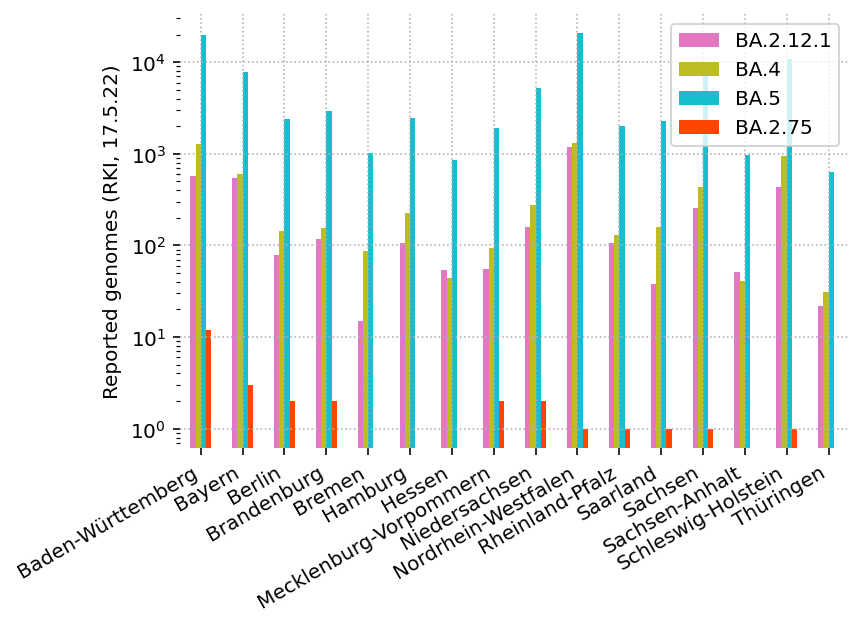

In [561]:
w = ["BA.2.12.1","BA.4","BA.5","BA.2.75"]
f.iloc[:-1,:].loc[:,w].plot.bar(color=[lineage_colors[x] for x in w])
plt.ylabel("Reported genomes (RKI, 17.5.22)")
plt.xticks(rotation=30, ha='right')
plt.yscale('log')

In [543]:
model.posterior['b1'].mean(0)[-1,0,:]

array([0.18888971, 0.1351215 , 0.16042008, 0.22854578, 0.29458237,
       0.37751514, 0.320946  , 0.3674609 , 0.34342888, 0.39356038,
       0.23774728, 0.        ], dtype=float32)

In [544]:
f = model.params['bc0_loc'].reshape(2,-1)[0,:]/100
f = np.append(f, -A[-1,:-1] @ f / A[-1,-1])
A @ f

array([0.18915004, 0.13509832, 0.16040821, 0.22850998, 0.29451886,
       0.37834939, 0.32098189, 0.36781539, 0.34347625, 0.39326886,
       0.23775297, 0.        ])

In [545]:
pd.Series(np.diff(model.get_logits().mean(0)[-1,-2:,:], axis=0)[0], index=merged_lineages)

B.1.1.529            0.188890
B.1.1.529.1          0.135121
B.1.1.529.1.1        0.160420
B.1.1.529.2          0.228546
B.1.1.529.2.12.1     0.294582
B.1.1.529.2.75       0.377515
B.1.1.529.4          0.320946
B.1.1.529.4.6        0.367461
B.1.1.529.5          0.343429
B.1.1.529.5.2.1.7    0.393560
Other                0.237747
B.1.617.2            0.000000
dtype: float64

In [546]:
w=np.append(model.params['day_mu'][2], 0)
np.exp(w-np.log(np.sum(np.exp(w ), keepdims=True))).sum()

0.9999999999999999

In [547]:
model.posterior.keys()

dict_keys(['b1', 'bc0', 'beta1', 'c1', 't', 'b0'])

In [548]:
λ = np.median(model.get_lambda_lineage(),0) / model.population[:,np.newaxis, np.newaxis]

In [549]:
λ.shape

(1, 301, 12)

In [550]:
λ[-1,-1]/λ[-1,-1].sum()

array([5.61047340e-10, 5.85343688e-13, 2.04140980e-10, 8.55361798e-05,
       1.72266657e-03, 1.93168633e-03, 1.72978774e-02, 1.08902483e-02,
       9.21032903e-01, 4.70375369e-02, 1.54415457e-06, 9.46570549e-27])

In [551]:
merged_lineages_alias

['B.1.1.529',
 'BA.1',
 'BA.1.1',
 'BA.2',
 'BA.2.12.1',
 'BA.2.75',
 'BA.4',
 'BA.4.6',
 'BA.5',
 'BA.5.2.1.7',
 'Other',
 'B.1.617.2']

In [569]:
y

BA.5.2.1.7        BA.5      BA.4.6        BA.4     BA.2.75  \
2021-11-02    0.000000    0.000000    0.000000    0.000000    0.000000   
2021-11-03    0.000000    0.000000    0.000000    0.000000    0.000000   
2021-11-04    0.000000    0.000000    0.000000    0.000000    0.000000   
2021-11-05    0.000000    0.000000    0.000000    0.000000    0.000000   
2021-11-06    0.000000    0.000000    0.000000    0.000000    0.000000   
...                ...         ...         ...         ...         ...   
2022-08-25   10.119894  246.733352  249.287195  254.256586  254.694618   
2022-08-26   10.000138  238.504509  240.966876  245.597122  246.024903   
2022-08-27    9.992102  227.554313  229.942728  234.188974  234.628460   
2022-08-28    9.952571  214.820223  217.154752  221.109894  221.523414   
2022-08-29    9.869736  203.127136  205.412202  209.041760  209.447080   

             BA.2.12.1        BA.2      BA.1.1        BA.1   B.1.617.2  
2021-11-02    0.000000    0.000000    0.000000    0.000000  184.212310  
2021-11-03    0.000000    0.000000    0.000000    0.000000  207.245985  
2021-11-04    0.000000    0.000000    0.000000    0.000000  228.165866  
2021-11-05    0.000000    0.000000    0.000000    0.000000  245.844264  
2021-11-06    0.000000    0.000000    0.000000    0.000000  274.255853  
...                ...         ...         ...         ...         ...  
2022-08-25  255.232154  255.267100  255.267100  255.267100  255.267100  
2022-08-26  246.505605  246.535076  246.535076  246.535076  246.535076  
2022-08-27  235.069869  235.094694  235.094694  235.094694  235.094694  
2022-08-28  221.919482  221.940364  221.940364  221.940364  221.940364  
2022-08-29  209.808542  209.826489  209.826489  209.826489  209.826489  

[301 rows x 10 columns]

IndexError: index 1 is out of bounds for axis 0 with size 1

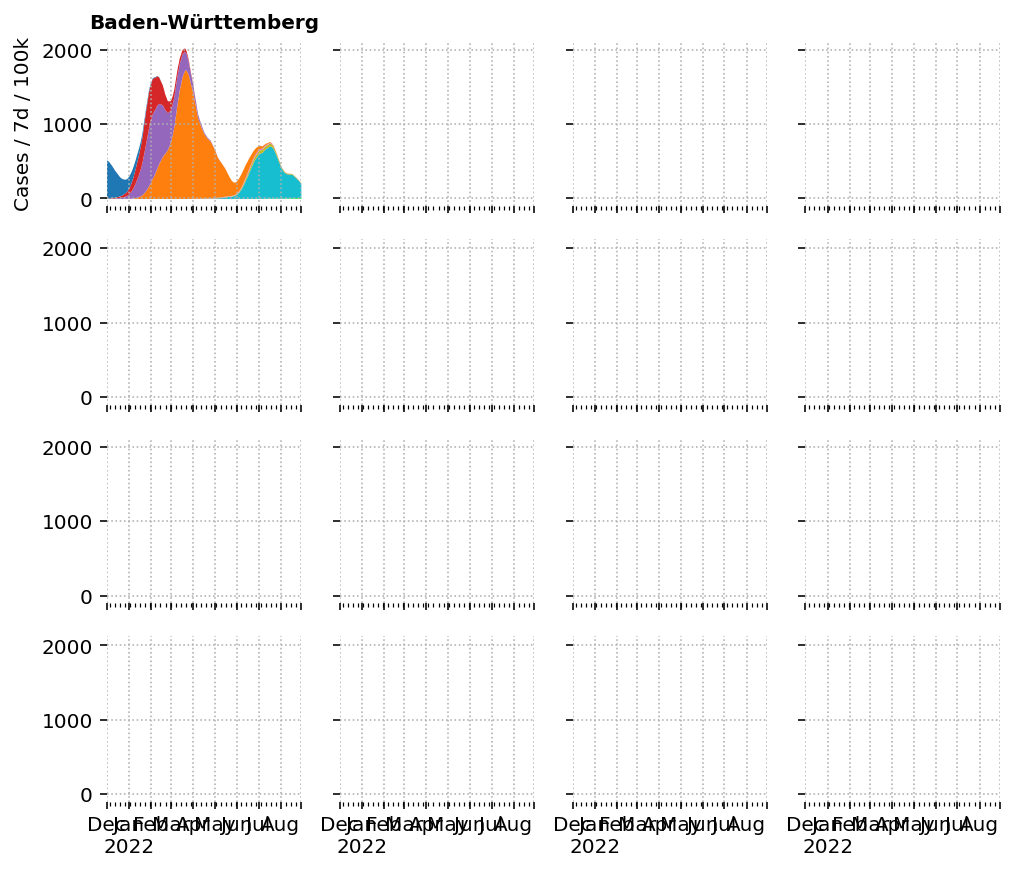

In [568]:
fig, ax = plt.subplots(4,4, figsize=(8,7), sharex=True, sharey=True)
ax = ax.flatten()
#col = ['C7','C3',"C4","C1", "C6","C5","C8" ,"C9", "C7","C0"]
#labels =[alias(x) for x in merged_lineages]
col = lineage_colors #dict(zip(labels, col))
for i,r in enumerate(cases_land.index):
    y = pd.DataFrame(λ[i,:,:], columns=lineage_colors.keys(), index=cases_land.columns[1] + np.arange(λ.shape[1]).astype('timedelta64[D]')) #cases_land.loc[r].loc["2021-12-01":,'AnzahlFall'] / capita[r] * 1000 #* 700
    y = y.drop(columns=["B.1.1.529","Other"])
    y = y.iloc[:,[i-1  for i in range(y.shape[1])]].iloc[:,::-1].cumsum(1)* 1000 * 700
    #y.index.name = 'date'
    #x = prop_bl.loc[r,:,:][0].unstack()
    #z = x[0.5] * y
    y["BA.1"].plot(ax=ax[i], ls="", label="")
    #(cases_land.loc[r]/capita[r]*1000 * 700).plot(ax=ax[i], marker=".", markersize=1.3, color="k", ls="", label="")
    for j in range(y.shape[1]):
        ax[i].fill_between(y.index, y.iloc[:,j-1] if j > 0 else 0, y.iloc[:,j], color=col[y.columns[j]], alpha=1, lw=0, label=y.columns[j])
    #ax[i].fill_between(y.index, y["BA.2"], y["BA.1"], color='C3', alpha=1, lw=0, label="BA.1")
    #ax[i].fill_between(y.index, y["B.1.617.2"], y["BA.2"], color='C1', alpha=1, lw=0, label="BA.2")
    #ax[i].fill_between(y.index, y["B.1.617.2"], color='C0', alpha=.5, lw=0, label="B.1.617.2")
    #ax[i].fill_between(z.index, y-x[0.95]*y, y-x[0.5]*y, color='none',alpha=1, lw=0, label="Omicron", hatch="//////", edgecolor="C3")
    ax[i].set_title(r, size=10 , weight='bold')
    ax[i].set_xlabel(None)
    ax[i].set_ylabel("Cases / 7d / 100k")
    ax[i].grid(ls=":")
    ax[i].set_xlim(("2021-12-01",None))
    #ax[i].set_yscale("log")
    #ax[i].set_ylim((0,100))

    for a in ax[i].spines.values():
        a.set_visible(False)
ax[-1].legend(title=None)
plt.tight_layout()
#fig.savefig("plots/omi_abs_by_area.png",dpi=200,bbox_inches='tight',pad_inches=0.2)

In [553]:
λ[-1,-1] / λ[-1,-1].sum()

array([5.61047340e-10, 5.85343688e-13, 2.04140980e-10, 8.55361798e-05,
       1.72266657e-03, 1.93168633e-03, 1.72978774e-02, 1.08902483e-02,
       9.21032903e-01, 4.70375369e-02, 1.54415457e-06, 9.46570549e-27])

In [554]:
plt.plot(λ[2].sum(1).cumsum()[:-1], cases_land.loc['Berlin'].cumsum() / capita[2])

IndexError: index 2 is out of bounds for axis 0 with size 1

In [555]:
from genomicsurveillance.misc import get_transmissibility

In [247]:
GG.shape

(17, 304, 16)

In [697]:
d = model.posterior['bc0'].mean(0).squeeze()[:GG.shape[-1]-1]

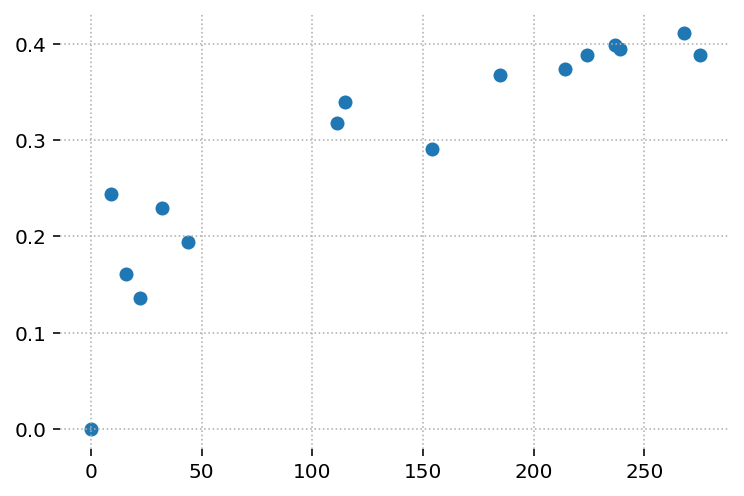

In [739]:
x = (GG[-1].cumsum(0)>0).argmax(0)
r = b.squeeze().mean(0)
plt.scatter(x, r)

In [740]:
f = np.einsum("...l,...l", model.get_probabilities(), b).squeeze()

In [749]:
r = b.squeeze()
from adjustText import adjust_text

7

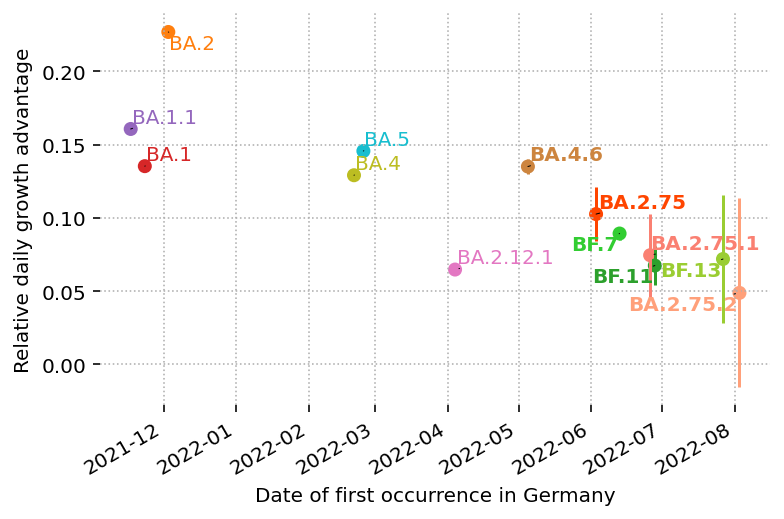

In [758]:
x = (GG[-1].cumsum(0)>0).argmax(0)
df = pd.DataFrame({"Growth advantage to Delta":r.mean(), "Relative growth advantage f":(r-f[:,x]).mean(0), "Lineage":merged_lineages_alias},index=cases_land.columns[x]).iloc[1:-2,:]
df["Relative growth advantage f"].plot(ls="")
plt.errorbar(df.index, df["Relative growth advantage f"], yerr=2*(r-f[:,x]).std(0)[1:-2], ls="", c=[lineage_colors[x] for x in df.Lineage])
plt.scatter(df.index, df["Relative growth advantage f"], marker='o', c=[lineage_colors[x] for x in df.Lineage])
text=[]
for x,y,s in zip(df.index.tolist(), df["Relative growth advantage f"],df.Lineage.tolist()):
    text.append(plt.text(x,y,s, ha='left', va='center', color=lineage_colors[s]))
plt.xlabel("Date of first occurrence in Germany")
plt.ylabel("Relative daily growth advantage")
for l in text:
    if re.match("|".join(["BA.2.75", "BA.4.6","BF"]),l.get_text()):
        l.set_weight('bold')
adjust_text(text, 
                #add_objects=line, 
                #expand_objects = (1,1),
                #force_objects =  (0, 0.2),
                #only_move=dict(objects='y', text='y', points='y'),
                arrowprops=dict(arrowstyle="-", color='k', lw=0.5), )

In [387]:
0.5 * x **2 * 0.0003

array([ 0.2904 ,  0.0726 ,  0.0384 ,  0.1536 ,  3.5574 ,  6.8694 ,
        8.42535, 11.34375,  1.84815,  5.13375,  1.98375,  7.5264 ,
        8.56815, 10.7736 ,  0.01215,  0.     ])

In [257]:
(r/x)[:-1].mean()

/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


0.004906264051261866

In [295]:
s = np.median(np.diff(r) / np.diff(x))

In [319]:
s

0.0005783551725847967

In [265]:
0.2/250

0.0008

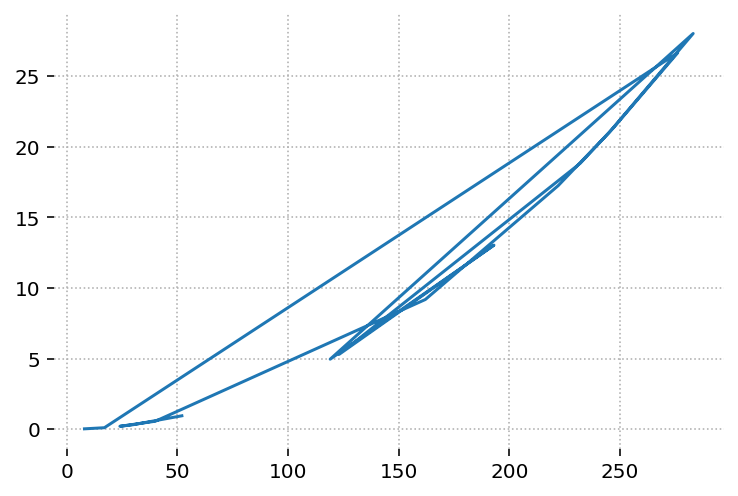

In [485]:
j = (model.clock()[0]==0).sum(1, keepdims=True).squeeze()
plt.plot(j,0.5 * j**2 * 0.0007)

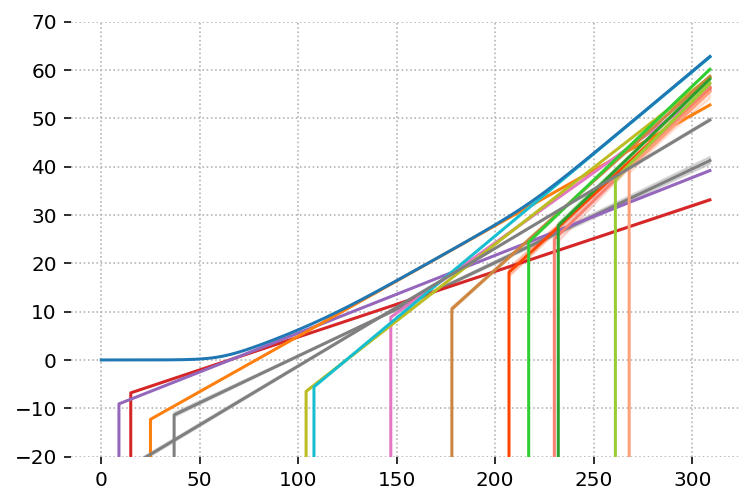

In [583]:
l = model.get_logits(ltla=-1).squeeze()
#m = 0.5 * (((r-r[0])/x)[:-1].mean()) * np.arange(l.shape[1])**2 + r[1]*np.arange(l.shape[1]) - 15#np.max(np.mean(l,0),-1)
for i in range(15):
    plt.plot(np.mean(l[...,i],0), c=lineage_colors[merged_lineages_alias[i]])
    plt.fill_between(x=np.arange(l.shape[1]), y1=np.quantile(l[...,i],0.05, 0), y2=np.quantile(l[...,i],0.95, 0), color=lineage_colors[merged_lineages_alias[i]], alpha=0.25)
plt.ylim((-20,70))
#l.shape
#plt.plot(seq_index, 0.5 * 0.0008 * seq_index**2)

from scipy.special import logsumexp
plt.plot(logsumexp(l.mean(0).squeeze(), -1))


#plt.plot(np.max(np.mean(l,0),-1))

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.14672766e-04, 1.34578237e-04, 1.58059018e-04,
       1.85591634e-04, 2.18010013e-04, 2.55909603e-04, 1.41472835e-03,
       1.62874081e-03, 1.87542906e-03, 2.15952704e-03, 2.48694886e-03,
       2.86430772e-03, 3.29915225e-03, 3.80043313e-03, 4.37801937e-03,
       5.04387775e-03, 5.81596466e-03, 6.70184940e-03, 7.72311492e-03,
       8.90037511e-03, 1.02576213e-02, 1.18221613e-02, 1.36255929e-02,
       1.57039389e-02, 1.80991553e-02, 2.08588075e-02, 2.40375977e-02,
       2.76981890e-02, 3.19306515e-02, 3.67830880e-02, 4.23640050e-02,
       4.87785339e-02, 5.61461374e-02, 6.46014884e-02, 7.42954090e-02,
       8.53968784e-02, 9.80936587e-02, 1.12593055e-01, 1.29122645e-01,
       1.47929966e-01, 1.69281885e-01, 1.93462893e-01, 2.20772207e-01,
       2.51520514e-01, 2.86024362e-01, 3.24600399e-01, 3.67557853e-01,
      

In [495]:
np.mean(model.posterior['c1'].squeeze(),0)

array([0.19212994, 0.13626212, 0.16137879, 0.22973387, 0.2952247 ,
       0.36870545, 0.3248579 , 0.33246928, 0.32164574, 0.37067533,
       0.34414303, 0.39125806, 0.3917118 , 0.39645866, 0.23961265,
       0.        ], dtype=float32)

In [518]:
np.max(np.mean(l,0),-1).shape

(310,)

In [524]:
np.where(((model.clock()[0]==0) * (model.clock()[1]==0)).squeeze().T)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 array([ 51,  29,  23,  39, 161, 221, 244, 282, 118, 192, 122, 231, 246,
        275,  16,   7]))

In [526]:
np.einsum('i,jil->jl',np.max(np.mean(l,0),-1),((model.clock()[0]==0) * (model.clock()[1]==0))[:,:310,:])

array([[ 0.        ,  0.        ,  0.        ,  0.        , 18.92071658,
        32.90725461, 40.82254371, 53.89997786,  9.04216055, 26.04246627,
         9.961096  , 36.34868465, 41.51082972, 51.49097684,  0.        ,
         0.        ]])

In [503]:
j

DeviceArray([ 52,  30,  24,  40, 162, 222, 245, 283, 119, 193, 123, 232,
             247, 276,  17,   8], dtype=int32)

In [493]:
np.max(np.mean(l,0),-1)[np.array(j)]

array([ 0.        ,  0.        ,  0.        ,  0.        , 19.15045044,
       33.25139762, 41.16668671, 54.24412087,  9.27189441, 26.27220014,
       10.19082986, 36.69282766, 41.85497272, 51.83511984,  0.        ,
        0.        ])

n  Growth rate r to ancestor      +/-   \
Lineage                                                  
B.1.1.529    1518                   0.189028  0.001854   
BA.1        57357                  -0.053628  0.001898   
BA.1.1     109615                   0.024995  0.000501   
BA.2       259279                   0.039686  0.001853   
BA.2.12.1    3791                   0.065663  0.001049   
BA.2.75        28                   0.145459  0.009481   
BA.2.75.1      14                   0.027189  0.018888   
BA.2.75.2       6                  -0.007871  0.053625   
BA.4         5979                   0.131787  0.002091   
BA.4.6        382                   0.048898  0.003176   
BA.5        89025                   0.154338  0.001985   
BF.7          703                   0.047275  0.002743   
BF.11          82                   0.047980  0.007905   
BF.13          17                   0.062750  0.022468   
Other        1523                   0.238797  0.001540   
B.1.617.2  119357                   0.000000  0.000000   

           Growth rate r to baseline BA.5       +/-  
Lineage                                              
B.1.1.529                       -0.154338  0.001854  
BA.1                            -0.207966  0.000504  
BA.1.1                          -0.182970  0.000354  
BA.2                            -0.114651  0.000270  
BA.2.12.1                       -0.048989  0.001023  
BA.2.75                          0.030808  0.009475  
BA.2.75.1                        0.057996  0.016846  
BA.2.75.2                        0.022937  0.054598  
BA.4                            -0.022551  0.000915  
BA.4.6                           0.026347  0.003121  
BA.5                             0.000000  0.000586  
BF.7                             0.047275  0.002796  
BF.11                            0.047980  0.007922  
BF.13                            0.062750  0.022473  
Other                           -0.104569  0.001540  
B.1.617.2                       -0.343366  0.000000

/Users/mg14/Git/desh-data/genomicsurveillance/misc/misc.py:925: RuntimeWarning: divide by zero encountered in log
  ax3 = plt.gca().secondary_yaxis('right', functions=(lambda x: np.exp(x*model.tau), lambda x: np.log(x)/model.tau))


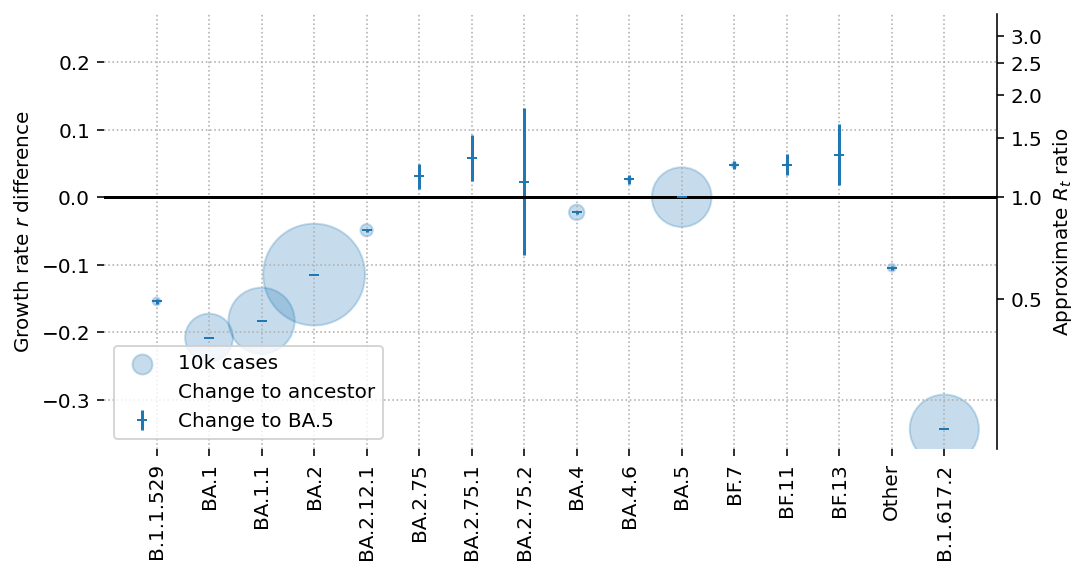

In [224]:
plt.figure(figsize=(8,4))
plot_growth_rates(model, [alias(x) for x in merged_lineages], color=["C0","None"], baseline="BA.5")

In [360]:
import geopandas as gpd

In [381]:
bl = gpd.read_file("data/bundeslaender.geojson").set_index("bundesland")

In [382]:
bl

land  \
bundesland                            
Baden-Württemberg       Deutschland   
Bayern                  Deutschland   
Berlin                  Deutschland   
Brandenburg             Deutschland   
Bremen                  Deutschland   
Hamburg                 Deutschland   
Hessen                  Deutschland   
Mecklenburg-Vorpommern  Deutschland   
Niedersachsen           Deutschland   
Nordrhein-Westfalen     Deutschland   
Rheinland-Pfalz         Deutschland   
Saarland                Deutschland   
Sachsen                 Deutschland   
Sachsen-Anhalt          Deutschland   
Schleswig-Holstein      Deutschland   
Thüringen               Deutschland   

                                                                 geometry  
bundesland                                                                 
Baden-Württemberg       MULTIPOLYGON (((7.63396 47.56122, 7.68592 47.5...  
Bayern                  MULTIPOLYGON (((9.63623 47.60202, 9.74582 47.6...  
Berlin                  POLYGON ((13.73143 52.41981, 13.73412 52.40198...  
Brandenburg             POLYGON ((14.03274 51.47500, 14.06259 51.44542...  
Bremen                  MULTIPOLYGON (((8.96595 53.05772, 8.98022 53.0...  
Hamburg                 MULTIPOLYGON (((10.21828 53.49923, 10.26573 53...  
Hessen                  MULTIPOLYGON (((8.90009 49.48187, 8.89974 49.5...  
Mecklenburg-Vorpommern  MULTIPOLYGON (((11.52874 54.07105, 11.51283 54...  
Niedersachsen           MULTIPOLYGON (((10.36397 51.55606, 10.36689 51...  
Nordrhein-Westfalen     MULTIPOLYGON (((6.16603 50.66186, 6.19337 50.6...  
Rheinland-Pfalz         POLYGON ((8.28766 48.99838, 8.23545 48.96749, ...  
Saarland                POLYGON ((7.31027 49.12958, 7.29356 49.11499, ...  
Sachsen                 POLYGON ((12.23908 50.24698, 12.26616 50.25888...  
Sachsen-Anhalt          POLYGON ((12.19559 51.14146, 12.24134 51.13061...  
Schleswig-Holstein      MULTIPOLYGON (((11.00454 54.45007, 11.01815 54...  
Thüringen               POLYGON ((10.59094 50.27180, 10.60497 50.29310...

In [383]:
λ.sum(0)[-1] / λ.sum((0,2))[-1]

array([2.15288522e-04, 4.90127999e-04, 7.29437608e-03, 9.88248995e-01,
       6.20893242e-04, 1.97671796e-17, 1.93590697e-03, 1.19441189e-03,
       9.26731679e-11])

In [384]:
de = bl.copy()
de.geometry = de.buffer(1e-2)
de = de.dissolve(by='land')

/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  


In [405]:
vmax

0.0010552848501374573

/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/geopandas/plotting.py:376: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/geopandas/plotting.py:376: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/geopandas/plotting.py:376: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/geopandas/plotting.py:376: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,


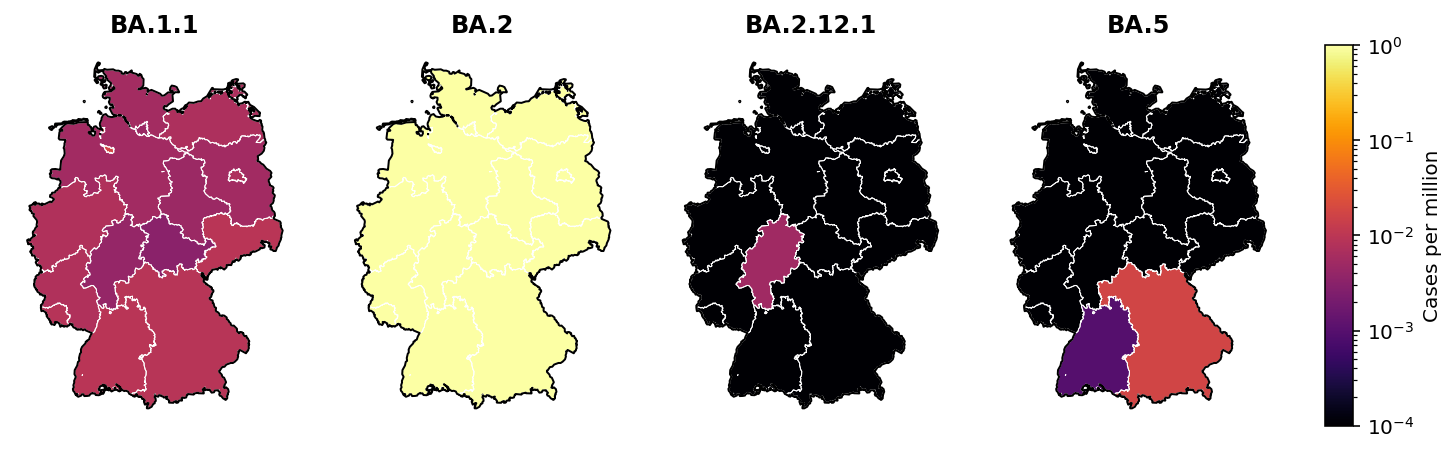

In [436]:
from matplotlib.colors import LogNorm
fig, axs = plt.subplots(1,5, figsize=(12,3.5), gridspec_kw={'width_ratios': [1, 1,1,1,0.1]})
for ax in axs[:-1]:
    ax.axis("off")
#camera = Camera(fig)
vmax = 1#1-1e-2 #λ[:-1,-1,:].max()
vmin = 1e-4
p = model.get_probabilities()
b0 = bl.copy().merge(pd.DataFrame(λ[:-1,-1,:]/λ[:-1,-1,:].sum(1, keepdims=True) + 1e-4, columns=[alias(x) for x in merged_lineages], index=bl.index), 
                     left_index=True, right_index=True)
for i, g in enumerate(["BA.1.1","BA.2","BA.2.12.1","BA.5"]):
    b0.plot(g, ax=axs[i], cmap="inferno",#["Purples","Oranges","GnBu","RdPu"][i], 
            norm=LogNorm(vmin=vmin, vmax=vmax), 
            cax=axs[4],
            legend_kwds={'label': "Cases per million", 'pad':0.3}, 
            legend=i==0, 
            missing_kwds= dict(color = "lightgrey"))
#b0.plot("BA.1.1", ax=axs[1], cmap="Purples", norm=LogNorm(vmin=vmin, vmax=vmax))
#b0.plot("BA.2", ax=axs[2], cmap="Oranges",norm=LogNorm(vmin=vmin, vmax=vmax))
#b0.plot("Other", ax=axs[3], cmap="Blues",norm=LogNorm(vmin=vmin, vmax=vmax))
    axs[i].set_title(g, weight='bold')
for ax in axs[:-1]:
    bl.boundary.plot(color='w',lw=0.5, ax=ax)
    de.boundary.plot(color='k',lw=1, ax=ax)

In [386]:
b0.iloc[:,2:] * capita.values.reshape(-1,1)

B.1.1.529      BA.1     BA.1.1          BA.2  \
bundesland                                                                
Baden-Württemberg       1.883543e+00  3.079631  52.642528   5634.712014   
Bayern                  9.239523e-01  7.011032  82.398169   8932.680753   
Berlin                  7.129156e-02  1.230208  15.494119   2098.838582   
Brandenburg             1.045944e-11  0.393579   7.313904   1355.588718   
Bremen                  1.695011e-12  0.718811   8.141248    440.112645   
Hamburg                 5.999631e-01  0.583647   9.072471   1954.758359   
Hessen                  5.292444e-14  1.638437  26.702307   6618.295355   
Mecklenburg-Vorpommern  8.967187e-02  0.376390   4.663220    664.720074   
Niedersachsen           3.970144e-07  1.786235  33.371726   6030.588211   
Nordrhein-Westfalen     4.840199e+00  7.301521  90.099141  11858.489882   
Rheinland-Pfalz         2.424459e-12  0.683199  27.570891   3611.656835   
Saarland                3.474684e-01  0.559327   9.063536   1038.390795   
Sachsen                 8.853864e-01  0.698149  15.200453   1586.023408   
Sachsen-Anhalt          8.796976e-03  0.275390   5.612932   1184.911661   
Schleswig-Holstein      1.297336e-12  1.193746  16.357342   2855.009578   
Thüringen               6.466811e-09  0.168431   2.454498    779.794371   

                           BA.2.12.1          BA.4          BA.5     Other  \
bundesland                                                                   
Baden-Württemberg       3.105715e-11  7.678868e-14  5.064922e+00  4.380167   
Bayern                  2.519557e-09  1.716826e-12  1.611692e+02  1.700485   
Berlin                  0.000000e+00  0.000000e+00  5.528965e-09  0.818255   
Brandenburg             0.000000e+00  0.000000e+00  0.000000e+00  1.760799   
Bremen                  0.000000e+00  0.000000e+00  0.000000e+00  1.139284   
Hamburg                 0.000000e+00  0.000000e+00  4.329695e-09  5.784102   
Hessen                  3.540015e+01  0.000000e+00  1.415664e-09  0.208422   
Mecklenburg-Vorpommern  0.000000e+00  0.000000e+00  0.000000e+00  0.227734   
Niedersachsen           0.000000e+00  0.000000e+00  1.259503e-07  9.591274   
Nordrhein-Westfalen     8.869462e-09  1.560993e-12  5.445674e-09  7.262824   
Rheinland-Pfalz         0.000000e+00  0.000000e+00  0.000000e+00  0.032172   
Saarland                0.000000e+00  0.000000e+00  0.000000e+00  1.823491   
Sachsen                 0.000000e+00  0.000000e+00  7.374251e-10  3.693537   
Sachsen-Anhalt          0.000000e+00  0.000000e+00  0.000000e+00  0.002043   
Schleswig-Holstein      1.139780e-09  0.000000e+00  5.317432e-08  6.993398   
Thüringen               0.000000e+00  0.000000e+00  6.953959e-09  0.239284   

                           B.1.617.2  
bundesland                            
Baden-Württemberg       4.010882e-07  
Bayern                  3.028661e-07  
Berlin                  1.005914e-07  
Brandenburg             3.421493e-07  
Bremen                  1.202942e-08  
Hamburg                 7.259104e-08  
Hessen                  7.024828e-08  
Mecklenburg-Vorpommern  4.142959e-08  
Niedersachsen           7.021541e-07  
Nordrhein-Westfalen     4.510040e-07  
Rheinland-Pfalz         3.389480e-07  
Saarland                2.721392e-08  
Sachsen                 8.016983e-08  
Sachsen-Anhalt          7.507915e-08  
Schleswig-Holstein      8.749001e-07  
Thüringen               8.240026e-08

In [65]:
r = model.get_growth_rate_lineage(ltla=None).mean(0)[:,-5,:]
r

array([[-1.17073431e-01, -8.72409463e-02, -2.49905770e-02,
        -3.33996603e-01, -2.40221833e-01, -2.56206262e-01],
       [-9.53045288e-02, -7.66980709e-02, -1.01037425e-02,
        -4.51850657e-01, -1.81135403e-01, -2.40760578e-01],
       [-8.50041977e-02, -6.02728009e-02, -4.07334947e-03,
        -2.27750612e-01, -2.02436696e-01, -2.27750612e-01],
       [-1.11172666e-01, -8.15255004e-02, -1.39356918e-02,
        -3.03596317e-01, -2.44137866e-01, -2.44137866e-01],
       [-5.44851079e-02, -3.83661998e-02,  3.11813242e-02,
        -1.96419871e-01, -1.40428822e-01, -1.96419871e-01],
       [-1.44524835e-01, -1.17987621e-01, -3.75336103e-02,
        -3.45094824e-01, -2.08678367e-01, -2.68897737e-01],
       [-1.17924524e-01, -9.33053921e-02, -1.65491929e-02,
        -3.16804863e-01, -2.15071610e-01, -2.47860992e-01],
       [-1.08861593e-01, -8.06443087e-02, -2.28301704e-02,
        -2.49512284e-01, -2.49512284e-01, -2.49512284e-01],
       [-1.23489015e-01, -9.37075788e-02, -2.636

/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/geopandas/plotting.py:376: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/geopandas/plotting.py:376: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/geopandas/plotting.py:376: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,
/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/geopandas/plotting.py:376: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,


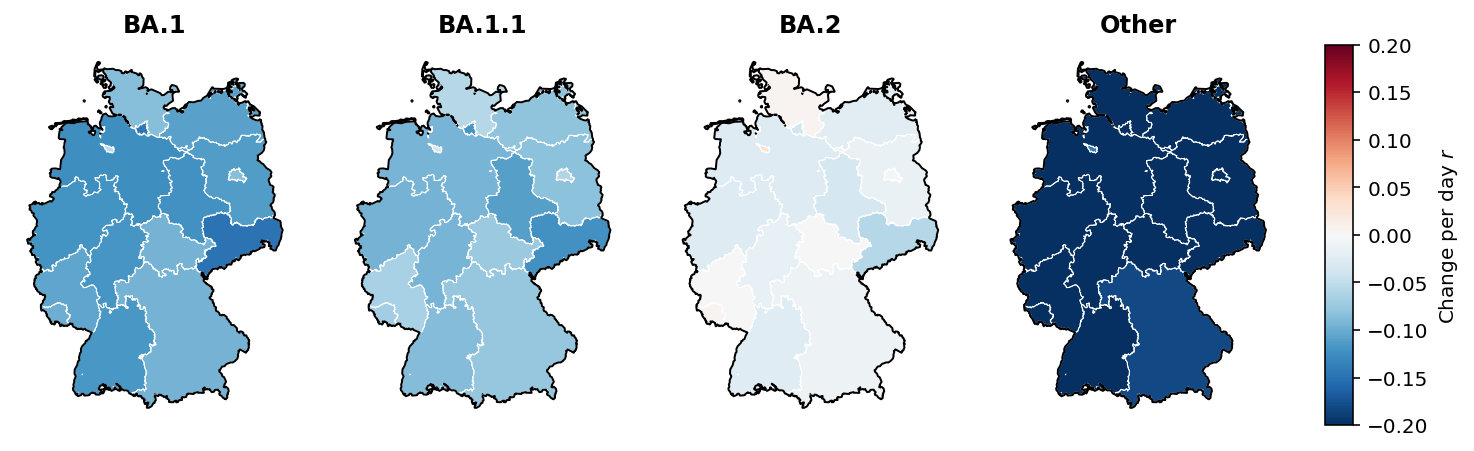

In [66]:
from matplotlib.colors import LogNorm
fig, axs = plt.subplots(1,5, figsize=(12,3.5), gridspec_kw={'width_ratios': [1, 1,1,1,0.1]})
for ax in axs[:-1]:
    ax.axis("off")
#camera = Camera(fig)
vmax = λ[:-1,-1,:].max()
vmin = 1e-4
d = pd.DataFrame(r[:-1,:], columns=genomes.columns, index=bl.index)
#d.loc["Sachsen-Anhalt"]=np.nan
b0 = bl.copy().merge(d, 
                     left_index=True, right_index=True)
b0.plot("BA.1", ax=axs[0], cmap="RdBu_r", vmin=-0.2,vmax=0.2, cax=axs[4], legend_kwds={'label': "Change per day $r$", 'pad':0.3}, legend=True, missing_kwds= dict(color = "lightgrey"))# norm=LogNorm(vmin=vmin, vmax=vmax))
b0.plot("BA.1.1", ax=axs[1], cmap="RdBu_r", vmin=-0.2,vmax=0.2,missing_kwds= dict(color = "lightgrey"))#, norm=LogNorm(vmin=vmin, vmax=vmax))
b0.plot("BA.2", ax=axs[2], cmap="RdBu_r", vmin=-0.2,vmax=0.2,missing_kwds= dict(color = "lightgrey"))#,norm=LogNorm(vmin=vmin, vmax=vmax))
b0.plot("Other", ax=axs[3], cmap="RdBu_r", vmin=-0.2,vmax=0.2,missing_kwds= dict(color = "lightgrey"))#,norm=LogNorm(vmin=vmin, vmax=vmax))
for i,ax in enumerate(axs[:-1]):
    ax.set_title(genomes.columns[[0,1,2,4]][i], weight='bold')
    bl.boundary.plot(color='w',lw=0.5, ax=ax)
    de.boundary.plot(color='k',lw=1, ax=ax)

In [67]:
from sklearn.linear_model import LinearRegression as LR
from adjustText import adjust_text
import re

In [68]:
j

24

0.07069868281110661
0.08626862616509487
0.04385605918808592
0.042607422277869476


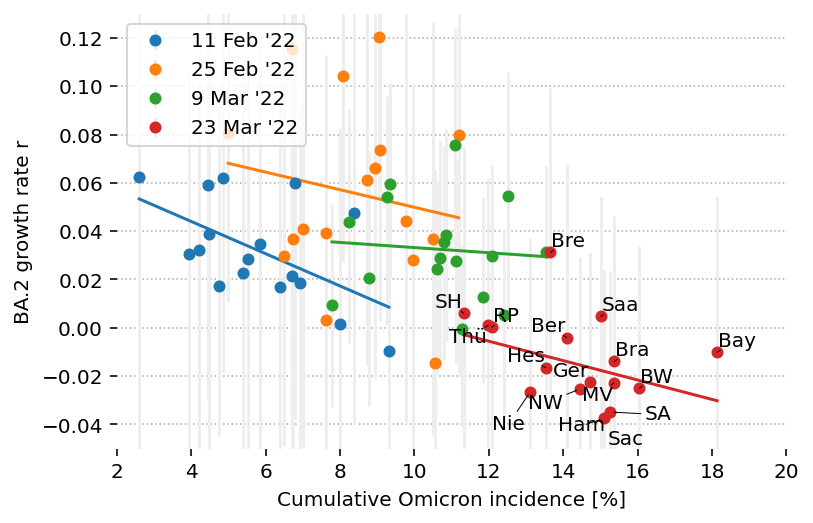

In [80]:
fig, axs = plt.subplots(1,1, figsize=(6,4), sharey=True)
#axs = axs.flatten()
text=[]
for k,l in enumerate(["2022-02-11", "2022-02-25","2022-03-09","2022-03-23"]):
    j = np.where(cases_land.columns == l)[0][0]
    ax = axs#[0]
    ci = np.quantile(model.get_growth_rate_lineage(ltla=None)[:,:,j,2], (0.1, 0.9), axis=0)
    r = model.get_growth_rate_lineage(ltla=None).mean(0)[:,j,:]

    lr = LR()
    x = λ[...,:j,:3].sum((1,2)) * 100
    y = r[:,2]
    lr.fit(x[:,np.newaxis], y)
    ax.errorbar(x, y, yerr=np.abs(ci - y[np.newaxis,:]), ls="", marker=".", ms=10,color=f'C{k}', ecolor='#EEEEEE', 
               label=cases_land.columns[j].strftime("%-d %b \'%y"))
    #ax.set_title(cases_land.columns[j].strftime("%-d %b \'%y"))

    l=[re.sub("[a-zöüä\-]","",x) if re.search("-",x) else x[:3] for x in (cases_land.index.to_list() + ['Germany'])]
    
    for i in range(x.shape[0]):
        if k==3:#l[i]#in ["BW","NW","RP","Saa"]:
            text.append(ax.text(x[i], y[i], l[i], color='k', va='bottom', ha='center'))
    x.sort()
    y = lr.predict(x[:,np.newaxis])
    line = ax.plot(x, y, ls="-", c=f'C{k}')
    #plt.axline((0, lr.intercept_), slope=lr.coef_)
    #plt.scatter(λ[...,:2].sum((1,2)), r[:,2])
    ax.set_xlabel("Cumulative Omicron incidence [%]")
    if k == 0: 
        ax.set_ylabel("BA.2 growth rate r") 
    ax.set_ylim((-0.05,0.13))
    ax.set_xlim((2,20))
    print(lr.intercept_)

adjust_text(text, 
                #add_objects=line, 
                #expand_objects = (1,1),
                #force_objects =  (0, 0.2),
                #only_move=dict(objects='y', text='y', points='y'),
                arrowprops=dict(arrowstyle="-", color='k', lw=0.5), )
ax.grid(axis='x', which='major')
ax.legend(loc='upper left')


In [70]:
λ[-1,-1,2]/ λ[-1,-1,:].sum()

0.9340922296138215

In [71]:
d = pd.DataFrame(model.get_growth_rate_lineage(ltla=None).mean(0)[:,[-24,-10],2], index=cases_land.index.to_list() + ["Germany"], columns=cases_land.columns[[-24,-10]])

<AxesSubplot:>

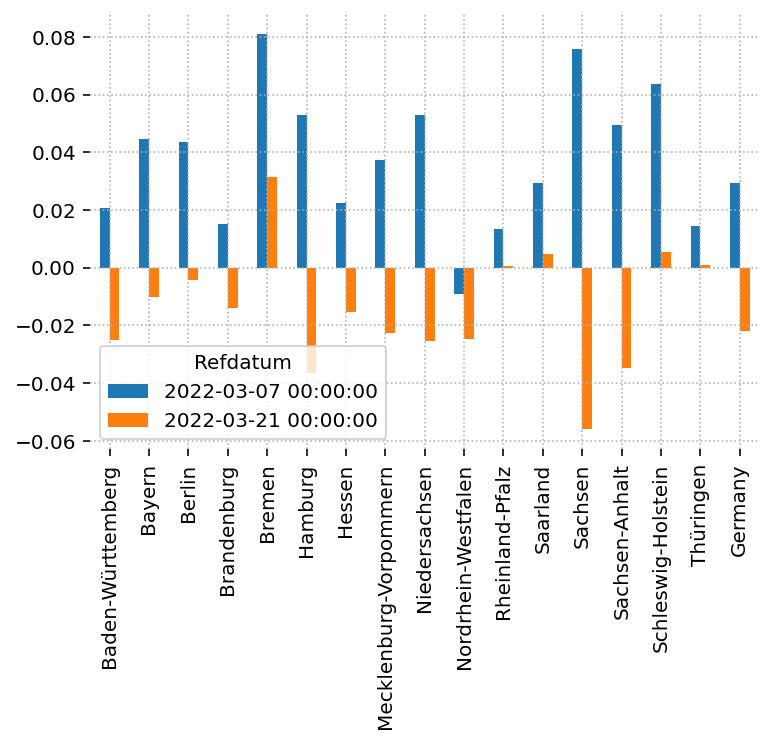

In [72]:
d.plot.bar()

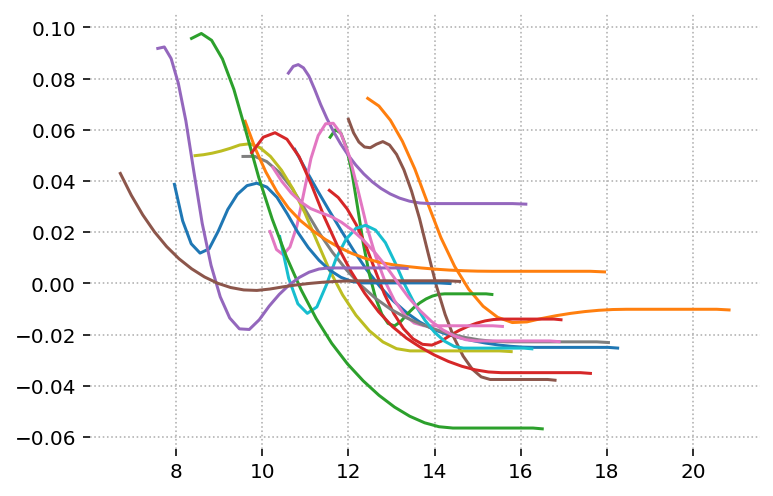

In [73]:
r = model.get_growth_rate_lineage(ltla=None).mean(0)[:,-28:,2]
x = λ[...,:,:3].sum(2).cumsum(1)[:,-28:] * 100
for i in range(r.shape[0]):
    plt.plot(x[i,:],r[i,:])

(18962.0, 19077.0)

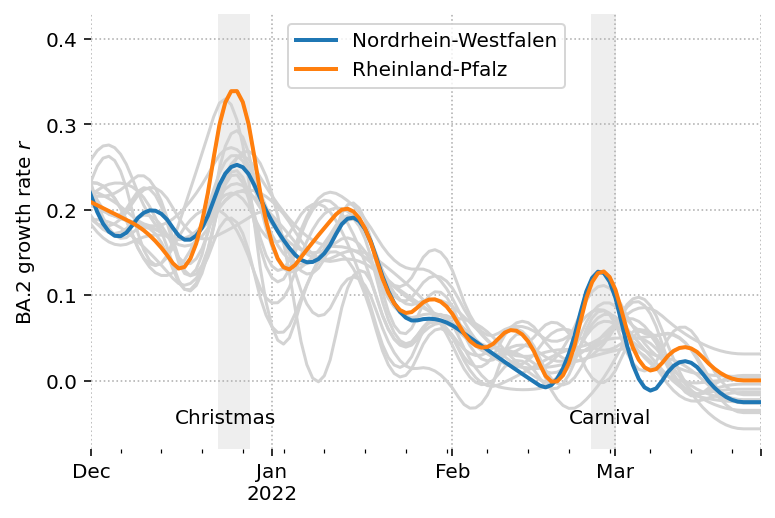

In [74]:
r = np.mean(model.get_growth_rate_lineage(ltla=None),0)[:,:,2]
r = pd.DataFrame(r.T[:-5], index=cases_land.columns[:-4].to_list(), columns=cases_land.index.to_list() + ["Germany"])
r.plot(c = 'lightgrey', alpha=1, legend=False)
r[["Nordrhein-Westfalen","Rheinland-Pfalz"]].plot( alpha=1, lw=2, ax=plt.gca())
#plt.legend("off")
plt.ylabel("BA.2 growth rate $r$")
plt.axvspan("2021-12-23","2021-12-28", color='#EEEEEE', zorder=0)
plt.axvspan("2022-02-25","2022-03-01", color='#EEEEEE', zorder=0)
plt.text("2021-12-24",-0.05,"Christmas", ha='center')
plt.text("2022-02-28",-0.05,"Carnival", ha='center')
plt.xlim(("2021-12-01",None))

In [64]:
from celluloid import Camera
from tqdm import tqdm
from matplotlib import colors


100%|██████████| 122/122 [00:42<00:00,  2.87it/s]


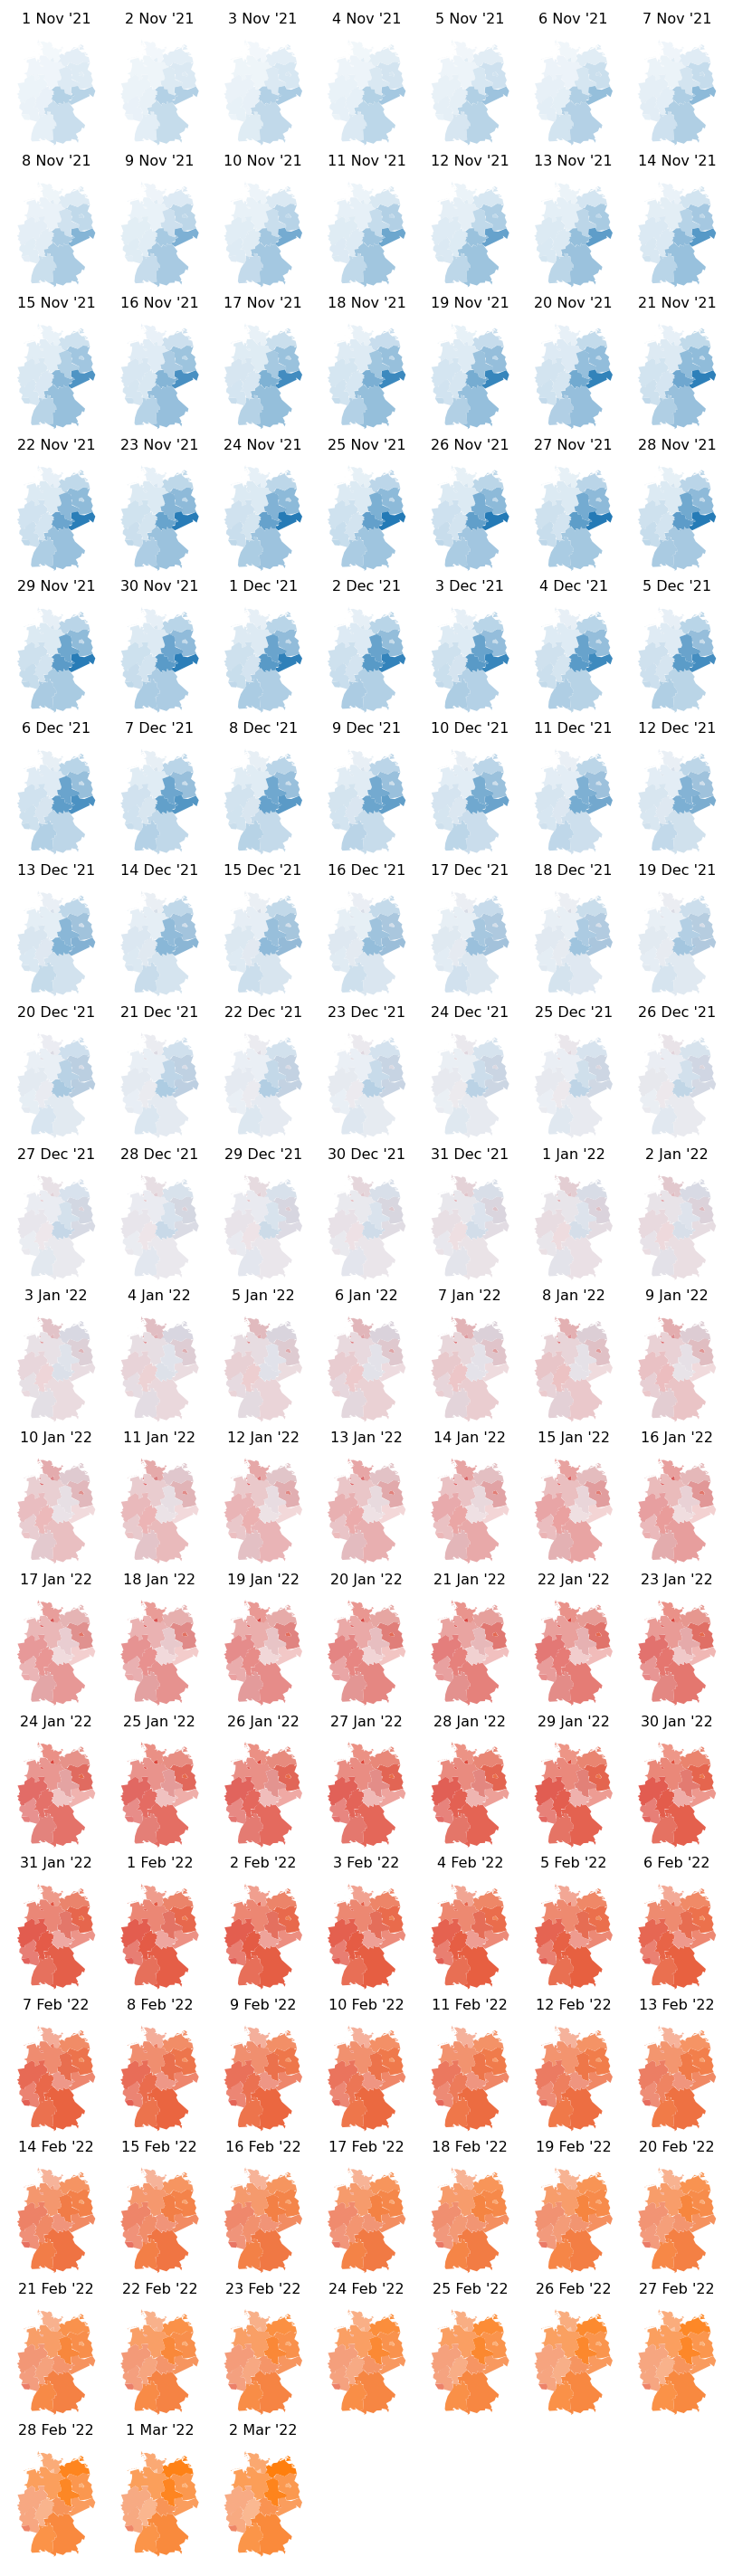

In [65]:
n = 7
m = (int(λ.shape[1]/7)+1)
fig, axs = plt.subplots(m,n, figsize=(7,10*m/n))
#camera = Camera(fig)
b0 = bl.copy().simplify(1e-1)
axs = axs.flatten()
for ax in axs:
    ax.axis("off")

    
def make_rgb_transparent(rgb, bg_rgb, alpha):
    return [alpha * c1 + (1 - alpha) * c2 for (c1, c2) in zip(rgb, bg_rgb)]

def alpha_to_color(alpha, c):
    c0 = []#(1,1,1)
    for x in alpha:
        cc = (1,1,1)
        for j, y in enumerate(x):
            cc = make_rgb_transparent(c[j ], cc, y)
        c0 += [cc]
    return c0

cols = [colors.colorConverter.to_rgb("C3"),
     colors.colorConverter.to_rgb("C3"),
     colors.colorConverter.to_rgb("C1"),
     colors.colorConverter.to_rgb("C0")]

for i in tqdm(range(λ.shape[1])): #λ.shape[1])
    ax = axs[i]
        
    #alpha = np.minimum(1, λ[:-1,i,[1,4]] * 700) #/λ.max()

    alpha = λ[:-1,i,[0,1,2,-1]]/λ.max()
    c = alpha_to_color(alpha, cols)

    ax.set_title((cases_land.columns[0] + np.timedelta64(i,"D")).strftime("%-d %b \'%y"), size=8)
    b0.plot(color=c, ax=ax)

    #bl.boundary.plot(color='w',lw=0.5, ax=ax)
    #de.boundary.plot(color='k',lw=1, ax=ax)
    #camera.snap()


In [66]:
f"{λ[:-1,-1,1] @ capita.values:0.0f}"

'37221'

In [67]:
λ.max()*700

1.4526477300739673

100%|██████████| 122/122 [07:36<00:00,  3.74s/it]


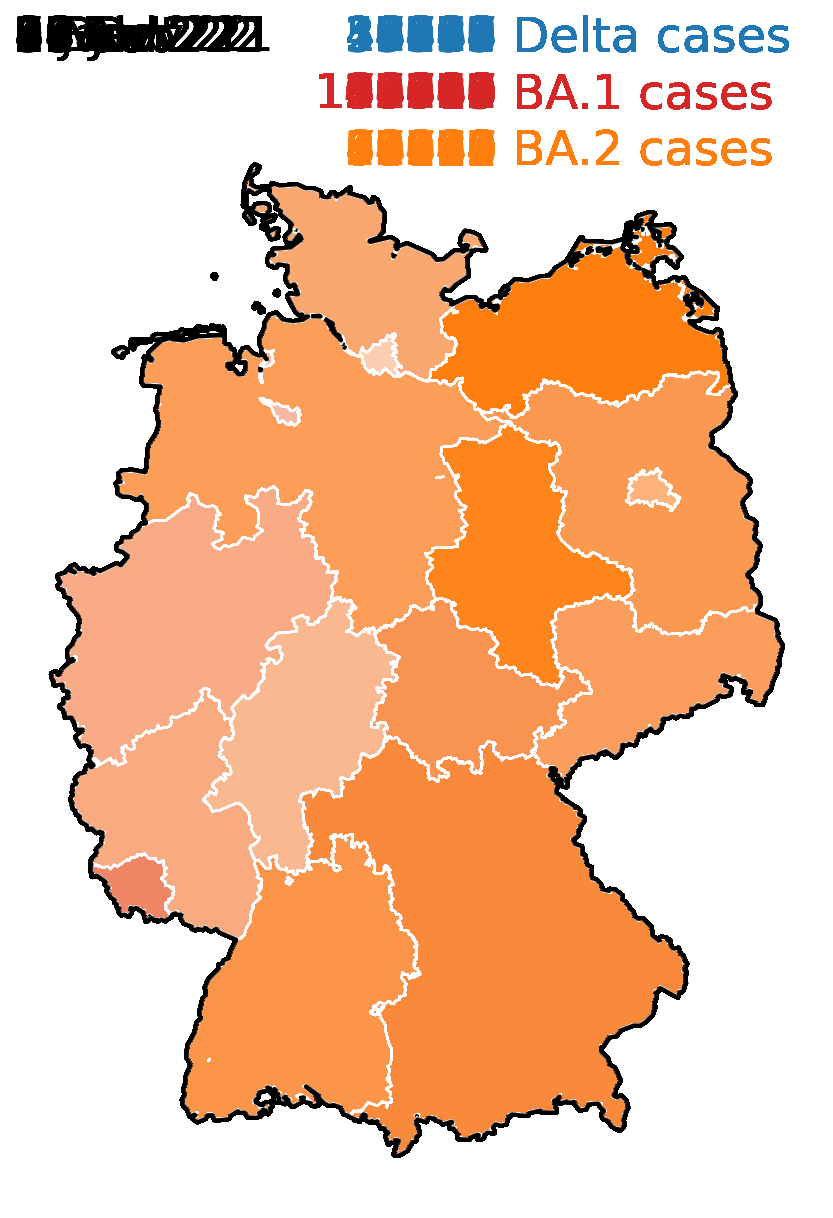

In [68]:
fig, ax = plt.subplots(1,1, figsize=(8,10.5), facecolor=None)
camera = Camera(fig)
b0 = bl.copy()#.simplify(1e-2)

ax.axis("off")

for i in tqdm(range(λ.shape[1])): #λ.shape[1])
    
    #alpha = np.minimum(1, λ[:-1,i,[1,4]] * 700) #/λ.max()
    alpha = λ[:-1,i,[0,1,2,-1]]/λ.max()
    c = alpha_to_color(alpha, cols)
    #c = [make_rgb_transparent(y, make_rgb_transparent(r, make_rgb_transparent(b, (1,1,1), x[2]), x[0]), x[1]) for x in alpha]
    b0.plot(color=c, ax=ax)

    #ax.set_title(cases_land.columns[i].strftime("%-d %b \'%y"), size=12)
    if i == 0:
        ax.set_ylim((None, ax.get_ylim()[0] + 1.05 * (ax.get_ylim()[1]-ax.get_ylim()[0])))
    
    ax.text(0.0, 1.01,  (cases_land.columns[0] + np.timedelta64(i,"D")).strftime("%-d %b \'%y"), size=24, transform=ax.transAxes)
    ax.text(0.6, 1.01,  f"{λ[:-1,i,-1] @ capita.values:0.0f}", color = "C0", size=24, transform=ax.transAxes, ha = 'right')
    ax.text(0.6, 0.96,  f"{λ[:-1,i,[0,1]].sum(-1) @ capita.values:0.0f}", color = "C3", size=24, transform=ax.transAxes, ha= 'right')
    ax.text(0.6, 0.91,  f"{λ[:-1,i,2] @ capita.values:0.0f}", color = "C1", size=24, transform=ax.transAxes, ha = 'right')
    ax.text(0.6, 1.01,  f" Delta cases", color = "C0", size=24, transform=ax.transAxes)
    ax.text(0.6, 0.96,  f" BA.1 cases", color = "C3", size=24, transform=ax.transAxes)
    ax.text(0.6, 0.91,  f" BA.2 cases", color = "C1", size=24, transform=ax.transAxes)

    bl.boundary.plot(color='w',lw=1, ax=ax)
    de.boundary.plot(color='k',lw=2, ax=ax)
    camera.snap()


In [69]:
animation = camera.animate(interval = 100, blit=True, repeat = False, repeat_delay=1000)

In [70]:
#import ffmpeg
from IPython.display import HTML
import re
HTML(re.sub("width=\"576\"","width=288",animation.to_html5_video()))

# UK analysis

In [209]:
import requests
cases_uk = pd.read_csv("https://api.coronavirus.data.gov.uk/v2/data?areaType=overview&metric=newCasesBySpecimenDate&format=csv", parse_dates=True, index_col=3)["newCasesBySpecimenDate"].sort_index().loc["2021-11-01":].iloc[:-1]

In [210]:
cases_uk

date
2021-11-01    45069
2021-11-02    37976
2021-11-03    35934
2021-11-04    33616
2021-11-05    30295
              ...  
2022-02-17    43559
2022-02-18    32333
2022-02-19    33861
2022-02-20    36757
2022-02-21    42078
Name: newCasesBySpecimenDate, Length: 113, dtype: int64

In [211]:
x = []
c = "United Kingdom"
for v in ['BA.1','BA.1.1', 'BA.2', 'BA.3', 'B.1.617.2*']:
    r = requests.get(f"https://lapis.cov-spectrum.org/gisaid/v1/sample/aggregated?fields=date&host=Human&country={c}&dateFrom=2021-11-01&dateTo={np.datetime64('today')}&pangoLineage={v}") #&dataVersion=1642092398
    d = pd.DataFrame(r.json()['data'])
    x.append(pd.DataFrame({v: d['count'].values}, index=pd.DatetimeIndex(d.date)).sort_index()[v])

genomes_uk = pd.DataFrame(x).T.fillna(0)#
genomes_uk = genomes_uk.loc[genomes_uk.index <= cases_uk.index.max(),:]
genomes_uk.sum(0)

BA.1          338473.0
BA.1.1        138324.0
BA.2           29613.0
BA.3              18.0
B.1.617.2*    372938.0
dtype: float64

In [212]:
genomes_uk = genomes_uk[genomes_uk.sum(1) > 100]

In [213]:
genomes_uk

BA.1  BA.1.1    BA.2  BA.3  B.1.617.2*
date                                                
2021-11-01     0.0     0.0     0.0   0.0      7781.0
2021-11-02     0.0     0.0     0.0   0.0      5999.0
2021-11-03     1.0     0.0     0.0   0.0      7031.0
2021-11-04     0.0     0.0     0.0   0.0      6415.0
2021-11-05     0.0     0.0     0.0   0.0      7034.0
...            ...     ...     ...   ...         ...
2022-02-12  1279.0  1889.0  1444.0   1.0         1.0
2022-02-13   635.0   983.0   856.0   0.0         1.0
2022-02-14   764.0  1270.0  1026.0   0.0         0.0
2022-02-15   368.0   617.0   593.0   0.0         1.0
2022-02-16    30.0    57.0    72.0   0.0         0.0

[108 rows x 5 columns]

In [214]:
genomes_uk["BA.1"][:"2021-11-18"] = 0
genomes_uk["BA.1.1"][:"2021-11-18"] = 0
genomes_uk["BA.2"][:"2021-12-18"] = 0

In [ ]:
date_split = np.datetime64("2021-12-14") + np.arange(0,8,2).astype("timedelta64[W]")#[np.datetime64("2021-12-12"), np.datetime64("2021-12-31")]
#bar[1,genomes_uk.index > d[1],:] = 0
#bar[2,genomes_uk.index <= d[1],:] = 0

In [216]:
date_split

array(['2021-12-14', '2021-12-28', '2022-01-11', '2022-01-25'],
      dtype='datetime64[D]')

In [217]:
foo = np.stack((len(date_split)+1) * [cases_uk["2021-11-01":].values], axis=0)
bar = np.stack((len(date_split)+1)  * [genomes_uk.values], axis=0)
for i, dd in enumerate(date_split):
    bar[i,genomes_uk.index > dd,:] = 0
    bar[i+1,genomes_uk.index <= dd,:] = 0


In [218]:
model_uk = MultiLineageTimeShift(
    foo, #cases_uk["2021-11-01":].values.reshape(1,-1),
    bar,    
    np.array([cases_uk.index.to_list().index(i) for i in genomes_uk.index]),
    np.repeat(67.22e6,len(date_split)+1),
    #auto_correlation=0.5,
    #linearize=True,
    arma = arma2,
    b_scale=0.05,
    b0_scale=0.5,
    c_scale=10.,
    beta_scale= np.append(10.,np.repeat(10., B0.shape[2]-1)),# np.concatenate([np.repeat(1., knots.num_long_basis), np.repeat(.1, knots.num_short_basis)]),
    tau=4.6,
    basis=B0, #knots.basis,
    shift=7,  
    alpha0=.01,
    alpha1=10000., 
    week=True,
    #model_kwargs={'handler':'SVI', 'loss':Trace_ELBO(num_particles=5), 'num_epochs':10000, 'lr':0.001, 'num_samples': 100}
    model_kwargs={'handler':'SVI', 'loss':Trace_ELBO(num_particles=10), 'num_epochs':10000, 'lr':0.005, 'lrd': 0.1 ** (1/10000), 'num_samples': 100}

)

In [219]:
model_uk.fit()

/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/jax/_src/numpy/lax_numpy.py:6576: UserWarning: Explicitly requested dtype float requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


KeyboardInterrupt: 

In [ ]:
plt.plot(model_uk.loss[2000:])
plt.xlabel('Epoch')
plt.ylabel('ELBO')

In [ ]:
import importlib
importlib.reload(gs.misc.misc)
importlib.reload(gs.misc)
from genomicsurveillance.misc import MultiLineageTimeShift, plot_lad, plot_growth_rates, get_transmissibility

In [ ]:
for j,i in enumerate(range(bar.shape[0]-1,-1, -1)):
    w = [0,1,2,4]#np.arange(genomes_uk.shape[1]) #if i == 2 else [0,2]
    plot_lad(model_uk, i, 
             #model_uk.cases, model_uk.lineages, np.array([cases_uk.index.to_list().index(i) for i in genomes_uk.index]), 
             start_date="2021-11-01", 
             show_start_date="2021-11-01",
            lin = w,
            labels = genomes_uk.columns[w],
            lin_colors=np.array(['C3','C4', "C1" ,"C9", "C0","C0"])[w],#, "C6", "C1","C8"],
            #labels=[alias(y) if alias(y) != "AY.121" else "Orf3a:202L" for y in x],#["B.1.1.7", 'Delta', "AY.4", 'B.1.617.2.5', "B.1.177"],
            case_color="grey",
            case_markercolor="lightgrey",
                figsize=(5,6),
                prop_err=False,
            clip_to_lineage_data = True,
             add = j,
            bleed_left = 1,
             bleed_right= 5 if j == 0 else 1,
             show_Rt = False,
             plot_s= True,
             plot_r = True
            )

ax=plt.gcf().get_axes()
    
ax[0].set_title("United Kingdom", size=12, weight='bold')
#ax[0].set_yscale("log")

ax[1].set_yscale("logit")
ax[1].set_ylim((1e-4,1-1e-2))
ax[2].set_ylim((-.2,.45))
ax[1].legend(facecolor='white')
#ax[2].legend().remove()
ax[2].legend(loc='lower left')
ax[3].grid(False)
for i,a in enumerate(ax[:-1]):
    a.grid(ls=":")
    for dd in date_split:
        x = dd 
        if i ==2:
            x -= np.timedelta64(int(model.tau), "D")
            a.axvline(x, ls=":", color='k', lw=0.5)
#f = ax[2].xaxis.get_major_formatter()
#ax[1].xaxis.set_major_formatter(f)
#ax[1].set_xticklabels(ax[2].get_xticklabels(), visible=True)
#plt.setp(ax[1].get_xticklabels(),visible=True)
#plt.delaxes(ax[3])
#plt.delaxes(ax[0])
#ax[1].xaxis.set_tick_params(labelbottom=True)

#ax[1].xaxis.set_major_formatter(f)


In [ ]:
## import importlib
importlib.reload(gs.misc.misc)
importlib.reload(gs.misc)
from genomicsurveillance.misc import MultiLineageTimeShift, plot_lad, plot_growth_rates

In [ ]:
plt.figure(figsize=(4,4))
plot_growth_rates(model_uk, genomes_uk.columns.to_list(), color=["C0","None"], baseline="BA.1")


In [ ]:
bar.shape

In [ ]:
ax=plt.gcf().get_axes()

In [ ]:
ax

## Germany

In [358]:
foo = np.stack((len(date_split)+1) * [CC[-1]], axis=0)
bar = np.stack((len(date_split)+1)  * [GG[-1]], axis=0)
for i, dd in enumerate(date_split):
    bar[i,genomes.index.levels[1] > dd + np.timedelta64(2,"D"),:] = 0
    bar[i+1,genomes.index.levels[1] < dd - np.timedelta64(1,"D"),:] = 0
bar[0,:,2] = 0

In [359]:
model_de = MultiLineageTimeShift(
    foo, #cases_uk["2021-11-01":].values.reshape(1,-1),
    bar,    
    seq_index,
    np.repeat(capita.values.sum().reshape(1),len(date_split)+1),
    #auto_correlation=0.5,
    #linearize=True,
    arma = arma2,
    b_scale=0.05,
    b0_scale=0.5,
    c_scale=5,
    beta_scale= np.append(10.,np.repeat(10., B0.shape[2]-1)),# np.concatenate([np.repeat(1., knots.num_long_basis), np.repeat(.1, knots.num_short_basis)]),
    tau=4.6,
    basis=B0, #knots.basis,
    shift=7,  
    alpha0=.01,
    alpha1=10000., 
    week=True,
    #model_kwargs={'handler':'SVI', 'loss':Trace_ELBO(num_particles=5), 'num_epochs':10000, 'lr':0.001, 'num_samples': 100}
    model_kwargs={'handler':'SVI', 'loss':Trace_ELBO(num_particles=10), 'num_epochs':10000, 'lr':0.005, 'lrd': 0.1 ** (1/10000), 'num_samples': 100}

)

In [360]:
model_de.fit()

/Users/mg14/anaconda3/envs/npy/lib/python3.7/site-packages/jax/_src/numpy/lax_numpy.py:6576: UserWarning: Explicitly requested dtype float requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


SVI step 0 / 10,000 | 0 %
SVI step 1,000 / 10,000 | 10 %
SVI step 2,000 / 10,000 | 20 %
SVI step 3,000 / 10,000 | 30 %
SVI step 4,000 / 10,000 | 40 %
SVI step 5,000 / 10,000 | 50 %
SVI step 6,000 / 10,000 | 60 %
SVI step 7,000 / 10,000 | 70 %
SVI step 8,000 / 10,000 | 80 %
SVI step 9,000 / 10,000 | 90 %


Text(0, 0.5, 'ELBO')

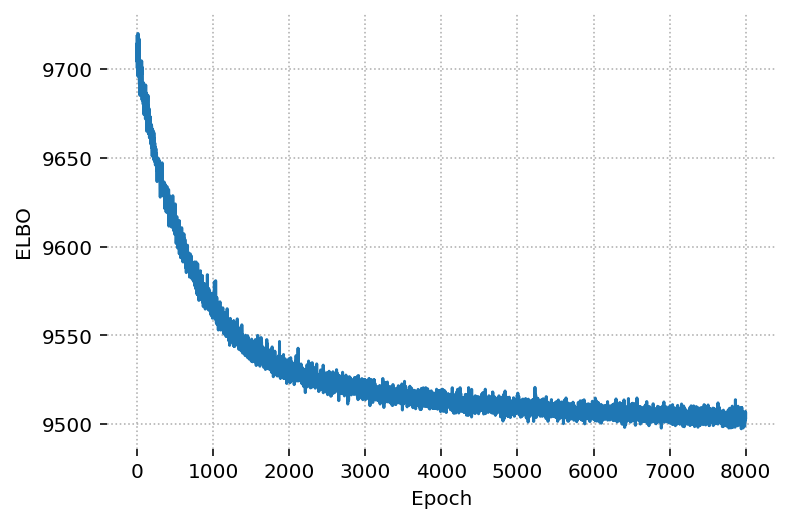

In [361]:
plt.plot(model_de.loss[2000:])
plt.xlabel('Epoch')
plt.ylabel('ELBO')

In [362]:
import importlib
importlib.reload(gs.misc.misc)
importlib.reload(gs.misc)
from genomicsurveillance.misc import MultiLineageTimeShift, plot_lad, plot_growth_rates, get_transmissibility

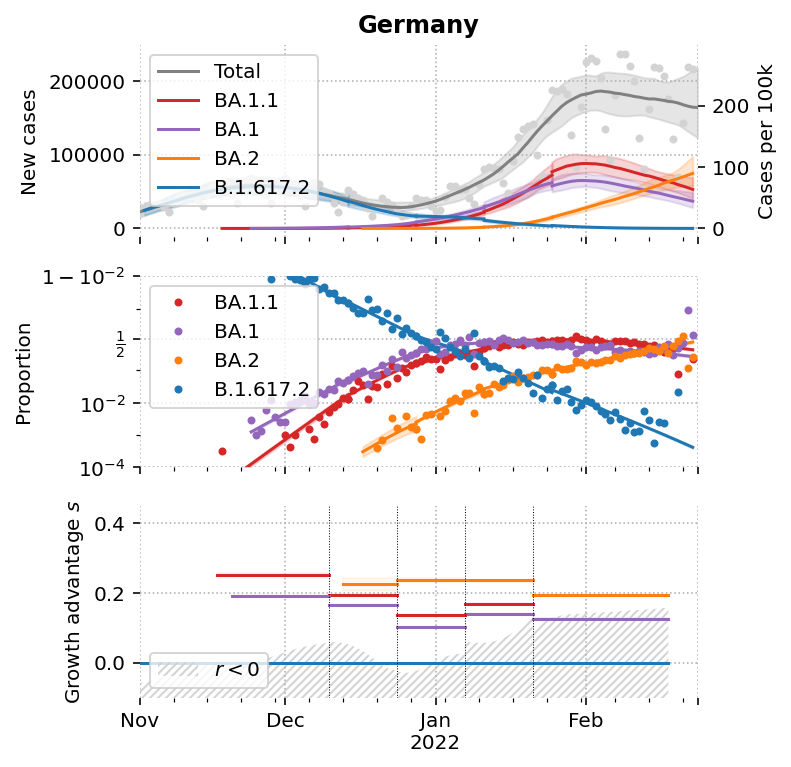

In [363]:
for j,i in enumerate(range(bar.shape[0]-1,-1, -1)):
    w = [1,0,2,5]#np.arange(genomes.shape[1]) #if i == 2 else [0,2]
    plot_lad(model_de, i, 
             #model_uk.cases, model_uk.lineages, np.array([cases_uk.index.to_list().index(i) for i in genomes_uk.index]), 
             start_date="2021-11-01", 
             show_start_date="2021-11-01",
            lin = w,
            labels = genomes.columns[w],
            lin_colors=np.array(['C4','C3', "C1" ,"C9", "C0","C0"])[w],#, "C6", "C1","C8"],
            #labels=[alias(y) if alias(y) != "AY.121" else "Orf3a:202L" for y in x],#["B.1.1.7", 'Delta', "AY.4", 'B.1.617.2.5', "B.1.177"],
            case_color="grey",
            case_markercolor="lightgrey",
                figsize=(5,6),
                prop_err=False,
            clip_to_lineage_data = True,
             add = j,
            bleed_left = -1,
             bleed_right= 5 if j == 0 else -1,
             show_Rt = False,
             plot_s= True,
             plot_r = True
            )

ax=plt.gcf().get_axes()
    
ax[0].set_title("Germany", size=12, weight='bold')

ax[1].set_yscale("logit")
ax[1].set_ylim((1e-4,1-1e-2))
ax[2].set_ylim((-.1,.45))
ax[1].legend(facecolor='white')
#ax[2].legend().remove()
ax[2].legend(loc='lower left')#.remove()
ax[3].grid(False)
for i,a in enumerate(ax[:-1]):
    a.grid(ls=":")
    for dd in date_split:
        x = dd 
        if i ==2:
            x -= np.timedelta64(int(model.tau), "D")
            a.axvline(x, ls=":", color='k', lw=0.5)
plt.delaxes(ax[3])



In [364]:
pd.DataFrame(get_transmissibility(model_de), columns=genomes.columns)

lineage      BA.1    BA.1.1      BA.2      BA.3     Other  B.1.617.2
0        0.191420  0.252462  0.021681  0.042103  0.074427        0.0
1        0.165376  0.194052  0.223760  0.042103  0.086572        0.0
2        0.102504  0.135664  0.237153  0.133593  0.063556        0.0
3        0.140669  0.169088  0.236354 -0.056527 -0.127477        0.0
4        0.124018  0.126526  0.194083  0.188843  0.192795        0.0

n  Growth rate r to ancestor      +/-   \
Lineage                                                  
BA.1        64760                   0.018187  0.031125   
BA.1.1      62333                   0.018127  0.045396   
BA.2        14991                   0.021681  0.017539   
BA.3           25                   0.042103  0.110309   
Other         274                   0.031535  0.103882   
B.1.617.2  137593                   0.000000  0.000000   

           Growth rate r to baseline BA.1       +/-  
Lineage                                              
BA.1                             0.000000  0.031125  
BA.1.1                           0.030761  0.045396  
BA.2                             0.078040  0.017539  
BA.3                            -0.056161  0.110309  
Other                           -0.086823  0.103882  
B.1.617.2                       -0.144798  0.000000

/Users/mg14/Downloads/desh-data/genomicsurveillance/misc/misc.py:876: RuntimeWarning: divide by zero encountered in log
  ax3.set_ylabel("Approximate $R_t$ ratio")


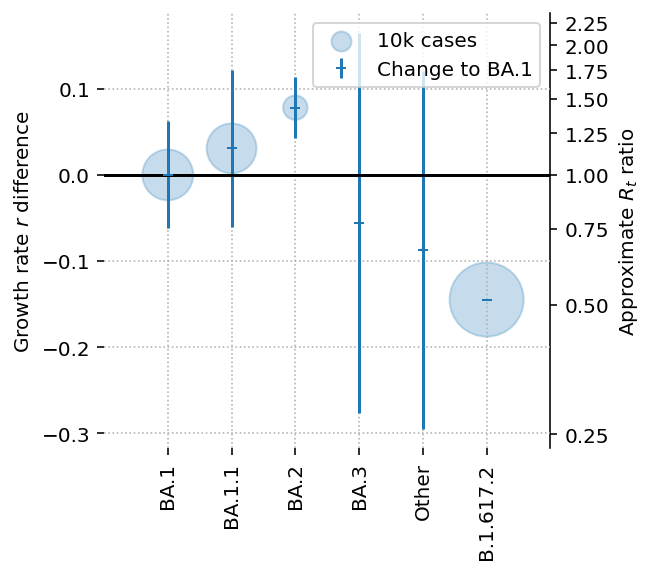

In [365]:
plt.figure(figsize=(4,4))
plot_growth_rates(model_de, genomes.columns.to_list(), color=["C0","None"], baseline="BA.1")


## Denmark

In [ ]:
cases_dk = pd.read_csv("../overvaagningsdata-dashboard-covid19-31012022-40ip/Regionalt_DB/08_bekraeftede_tilfaelde_pr_dag_pr_regions.csv", index_col=[0,1],parse_dates=True, encoding='latin_1', sep=";").sum(level=1).loc["2021-11-01":].iloc[:-1,0]

In [ ]:
cases_dk

In [ ]:
x = []
c = "Denmark"
for v in ['BA.1','BA.1.1', 'BA.2', 'BA.3', 'B.1.617.2*']:
    r = requests.get(f"https://lapis.cov-spectrum.org/gisaid/v1/sample/aggregated?fields=date&host=Human&country={c}&dateFrom=2021-11-01&dateTo={np.datetime64('today')}&pangoLineage={v}") #&dataVersion=1642092398
    d = pd.DataFrame(r.json()['data'])
    try:
        x.append(pd.DataFrame({v: d['count'].values}, index=pd.DatetimeIndex(d.date)).sort_index()[v])
    except:
        pass


genomes_dk = pd.DataFrame(x).T.fillna(0)#
genomes_dk = genomes_dk.loc[genomes_dk.index <= cases_dk.index.max(),:]
genomes_dk.sum(0)

In [ ]:
date_split = np.datetime64("2021-12-14") + np.arange(0,6,2).astype("timedelta64[W]")#[np.datetime64("2021-12-12"), np.datetime64("2021-12-31")]

In [ ]:
foo = np.stack((len(date_split)+1) * [cases_dk["2021-11-01":].values], axis=0)
bar = np.stack((len(date_split)+1)  * [genomes_dk.values], axis=0)
for i, dd in enumerate(date_split):
    bar[i,genomes_dk.index > dd,:] = 0
    bar[i+1,genomes_dk.index <= dd,:] = 0


In [ ]:
model_dk = MultiLineageTimeShift(
    foo, #cases_uk["2021-11-01":].values.reshape(1,-1),
    bar,    
    np.array([cases_dk.index.to_list().index(i) for i in genomes_dk.index]),
    np.repeat(5.831e6,len(date_split)+1),
    #auto_correlation=0.5,
    #linearize=True,
    arma = arma2,
    b_scale=0.1,
    b0_scale=0.5,
    c_scale=5,
    beta_scale= np.append(10.,np.repeat(10., B0.shape[2]-1)),# np.concatenate([np.repeat(1., knots.num_long_basis), np.repeat(.1, knots.num_short_basis)]),
    tau=4.6,
    basis=B0, #knots.basis,
    shift=7,  
    alpha0=.01,
    alpha1=10000., 
    week=True,
    #model_kwargs={'handler':'SVI', 'loss':Trace_ELBO(num_particles=5), 'num_epochs':10000, 'lr':0.001, 'num_samples': 100}
    model_kwargs={'handler':'SVI', 'loss':Trace_ELBO(num_particles=10), 'num_epochs':12000, 'lr':0.005, 'lrd': 0.1 ** (1/10000), 'num_samples': 100}

)

In [ ]:
foo.shape

In [ ]:
model_dk.fit()

In [ ]:
plt.plot(model_dk.loss[2000:])
plt.xlabel('Epoch')
plt.ylabel('ELBO')

In [ ]:
import importlib
importlib.reload(gs.misc.misc)
importlib.reload(gs.misc)
from genomicsurveillance.misc import MultiLineageTimeShift, plot_lad, plot_growth_rates, get_transmissibility

In [ ]:
for j,i in enumerate(range(bar.shape[0]-1,-1, -1)):
    w = [0,1,2,3]#np.arange(genomes.shape[1]) #if i == 2 else [0,2]
    plot_lad(model_dk, i, 
             #model_uk.cases, model_uk.lineages, np.array([cases_uk.index.to_list().index(i) for i in genomes_uk.index]), 
             start_date="2021-11-01", 
             show_start_date="2021-11-01",
            lin = w,
            labels = genomes_dk.columns[w],
            lin_colors=np.array(['C3','C4', "C1" ,"C0", "C0","C0"])[w],#, "C6", "C1","C8"],
            #labels=[alias(y) if alias(y) != "AY.121" else "Orf3a:202L" for y in x],#["B.1.1.7", 'Delta', "AY.4", 'B.1.617.2.5', "B.1.177"],
            case_color="grey",
            case_markercolor="lightgrey",
                figsize=(5,6),
                prop_err=False,
            clip_to_lineage_data = True,
             add = j,
            bleed_left = 1,
             bleed_right=3 if j ==0 else 1,
             show_Rt = False,
             plot_s= True
            )

ax=plt.gcf().get_axes()
    
ax[0].set_title("Denmark", size=12, weight='bold')

#ax[1].set_yscale("logit")
#ax[1].set_ylim((1e-4,1-1e-2))
ax[2].set_ylim((-.1,.45))
ax[1].legend().remove()
ax[1].legend(facecolor='white')
ax[2].legend(loc='lower right')#.remove()
ax[3].grid(False)
for i,a in enumerate(ax[:-1]):
    a.grid(ls=":")
    for dd in date_split:
        x = dd 
        if i ==2:
            x -= np.timedelta64(int(model.tau), "D")
            a.axvline(x, ls=":", color='k', lw=0.5)
plt.delaxes(ax[3])


In [ ]:
(bar[-1,-15:] )

In [ ]:
genomes_dk

In [ ]:
plt.figure(figsize=(4,4))
plot_growth_rates(model_dk, genomes_dk.columns.to_list(), color=["C0","None"], baseline="BA.1")
